In [ ]:
from google.colab import drive
from google.colab import files 
drive.mount('/content/drive/', force_remount= True)
import sys    
# path_to_module = "C:/Users/matthvr/Downloads/TESS-ZTF-Transient-Classification/"
path_to_module = '/content/drive/MyDrive/TESS-ZTF-Transient-Classification/'
sys.path.append(path_to_module)

# just testing this to see what happens

# import all needed libraries
# from pre_process.py
import warnings
import pandas as pd
import keras
import pickle
import numpy as np
from os import walk
import os
import matplotlib.pyplot as plt
import pickle as pkl
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm


Mounted at /content/drive/


In [ ]:
# from NN_model.py
import math
import random
import keras.backend as K
import tensorflow as tf
from keras import layers
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import (GRU, Dense, Lambda, Masking,
                          RepeatVector, TimeDistributed, concatenate)
from keras.optimizers import adam_v2
from sklearn.manifold import TSNE
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
warnings.filterwarnings("ignore")

In [ ]:
class_name_map={
    '90':      'SNIa-norm', 
    '42':      'SNII', 
    '62':      'SNIbc', 
    '43':      'CCSN', 
    '67':      'SNIa-91bg', 
    '52':      'SNIa-x', 
    '60':      'SLSN-I', 
    '64':      'TDE', 
    '99':      'Kilonova', 
    'II':    'II', 
    'IIn':   'II', 
    'IIb':   'Ibc', 
    'Ib':    'Ibc', 
    'Ic':    'Ibc', 
    'Ic-BL': 'Ibc'
}
SNIa = {'SNIa', 'SNI', 'SNIa-91T-like',
        'SNIa-91bg-like', 'SNIa-pec', 'SNIa-SC', 'SNIa-x', 'SNIa-91bg', 'SNIa-norm'}
SNIbc = {'SNIbn', 'SNIb/c', 'SNIb', 'SNIc', 'SNIc-BL', 'Ibc', 'SNIbc'}
SNIi = {'SNII', 'SNIIb', 'SNIIP', 'SNII-pec', 'SNIIn', 'II'}
other = {'CV', 'SLSN-I', 'AGN', 'FRB', 'Mdwarf',
        'Nova', 'Other', 'Varstar', 'TDE', 'Kilonova', 'CCSN'}
def modify_class(name):
    """
    Numerically encodes class names
    """
    if name in SNIa:
        return 0
    elif name in SNIbc:
        return 1
    elif name in SNIi:
        return 2
    elif name == 'Unclassified':
        return 3
    else:
        return 4
data = None
with open(path_to_module + 'light_curves_sims/trial_2/numpy_files/dataset.pickle', 'rb') as file:
  data = pickle.load(file)
# data is list of numpy arrays:
# first array is light curve names
# second one is light curve labels
# third one is light curves
names, labels, dataset = data

labels = np.array([int(label) for label in labels])
print(names)
print(labels)
print(Counter(labels))

['67_4865751' '67_2938898' '67_2124114' ... '60_10006930' '64_14885243'
 '99_3042554']
[0 0 0 ... 4 4 4]
Counter({0: 2000, 1: 2000, 2: 2000, 4: 2000})


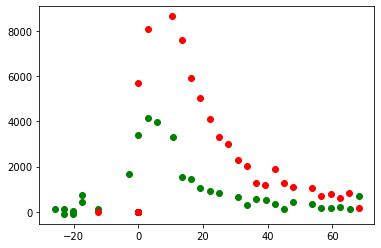

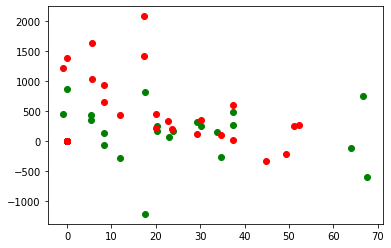

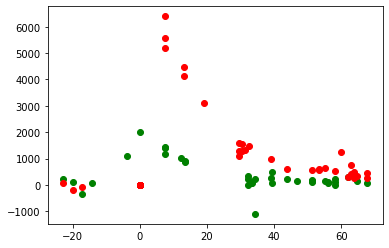

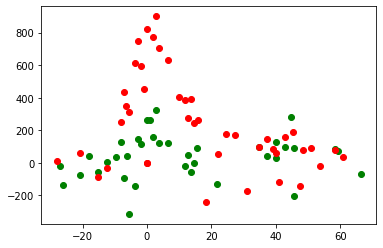

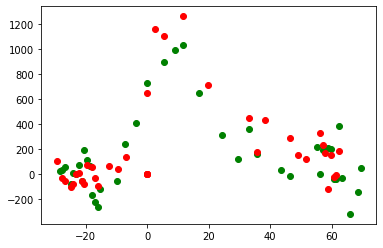

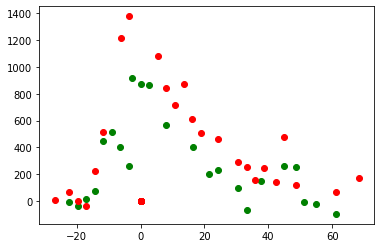

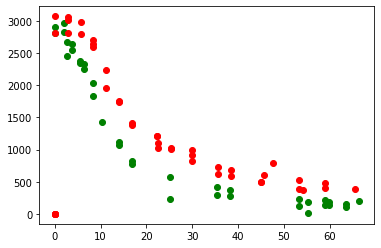

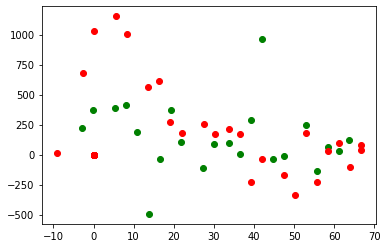

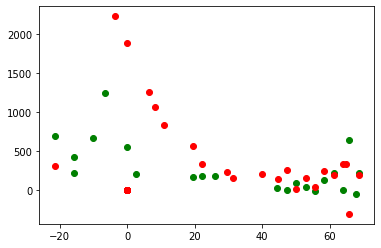

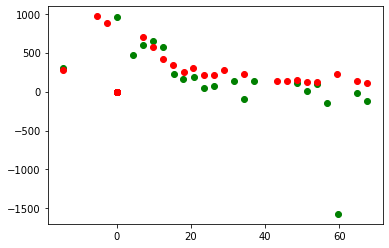

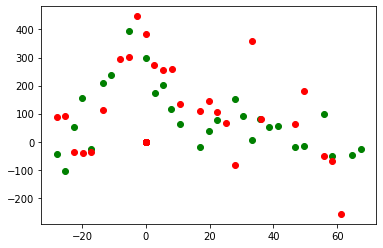

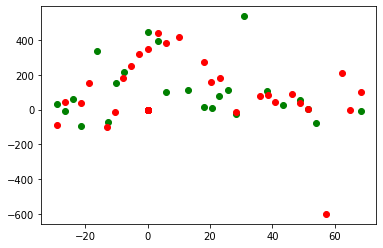

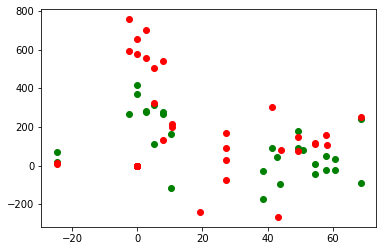

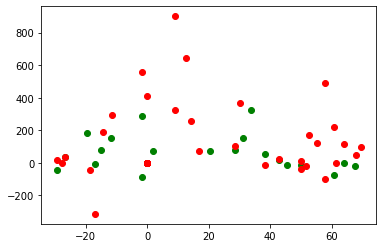

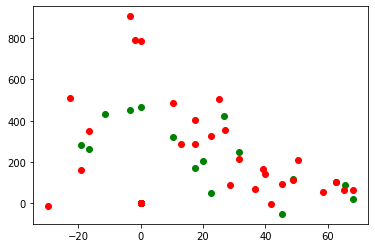

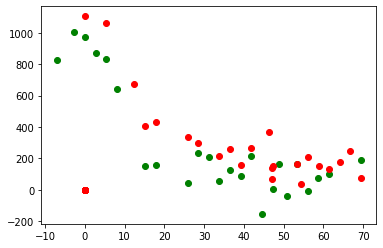

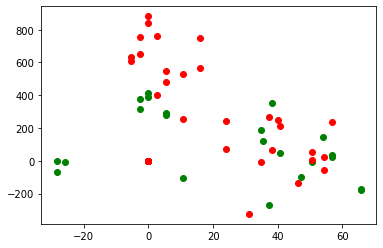

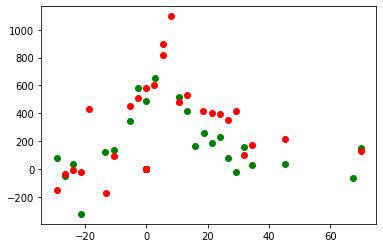

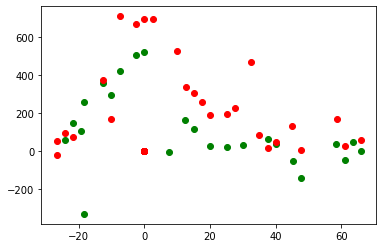

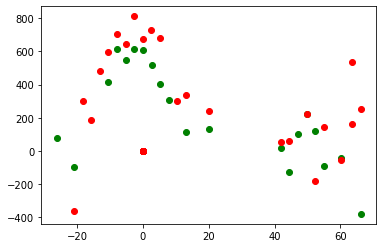

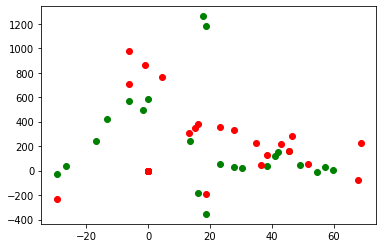

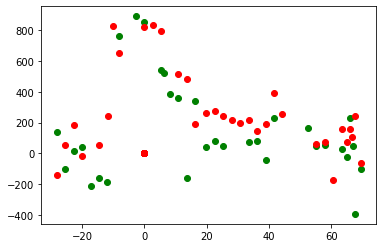

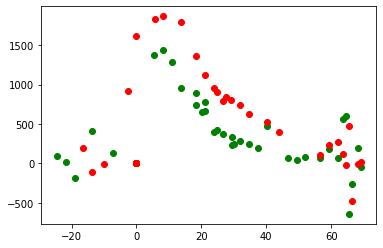

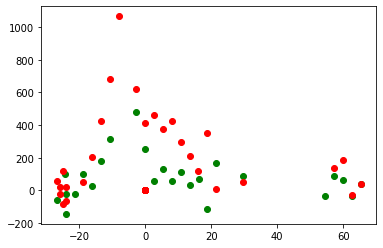

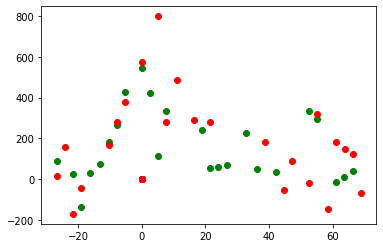

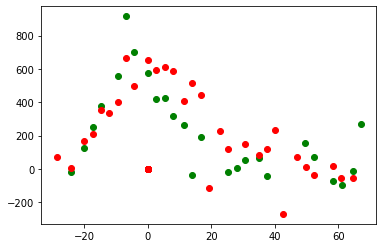

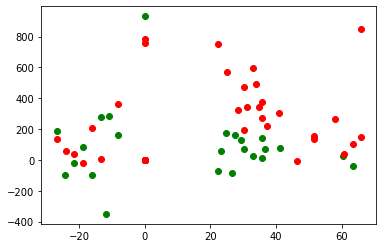

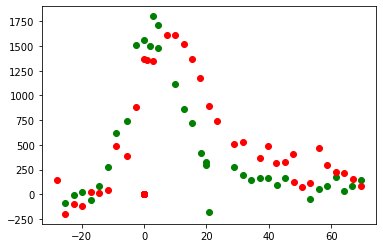

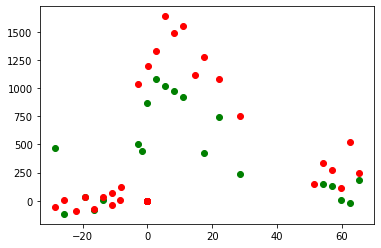

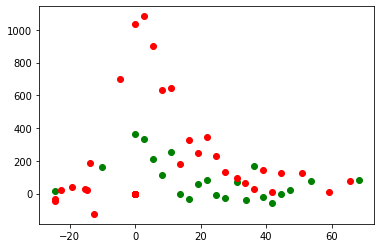

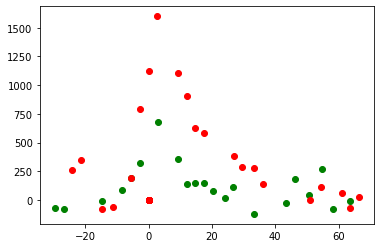

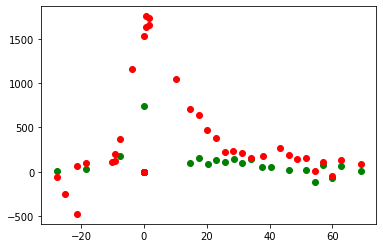

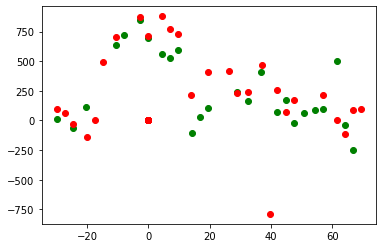

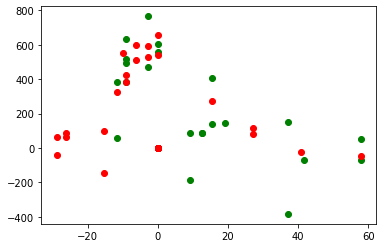

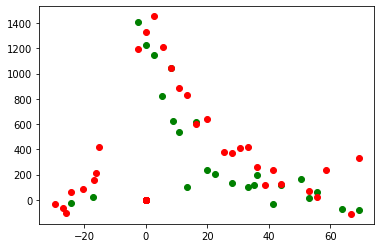

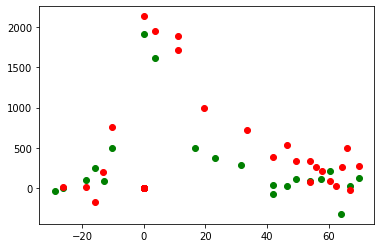

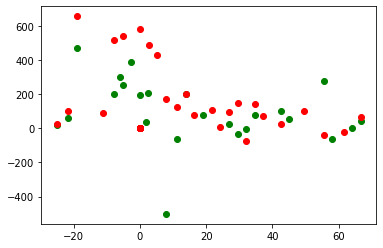

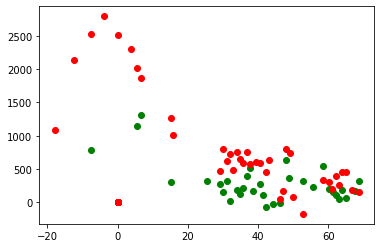

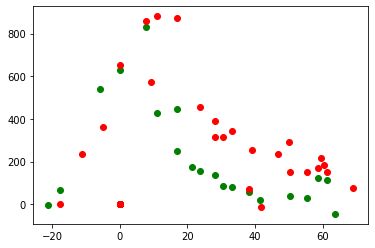

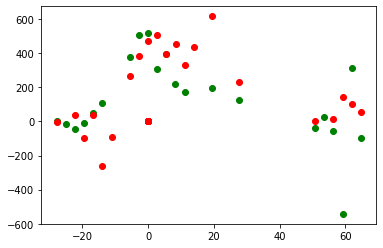

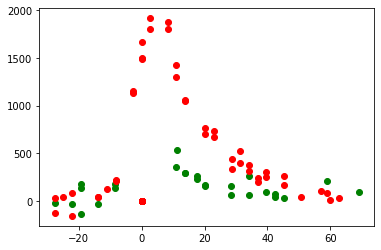

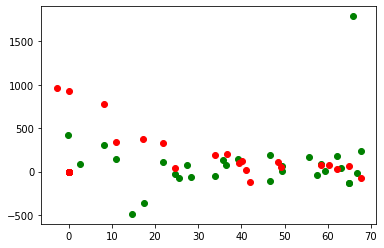

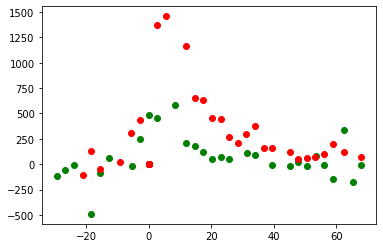

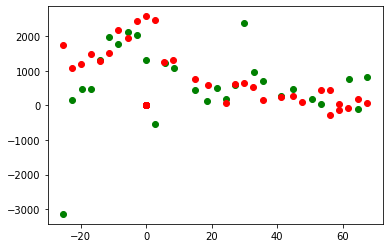

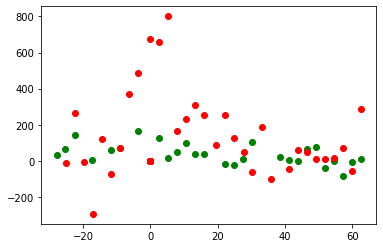

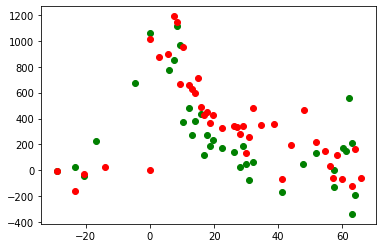

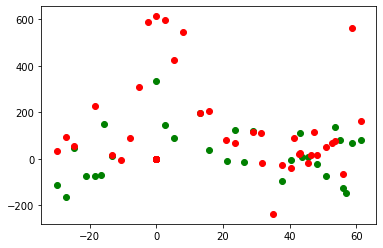

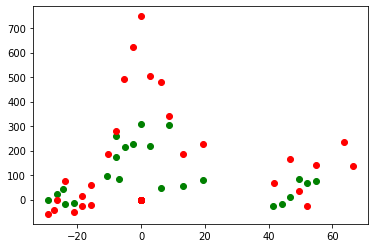

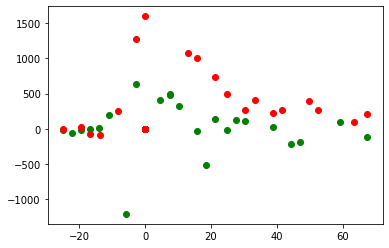

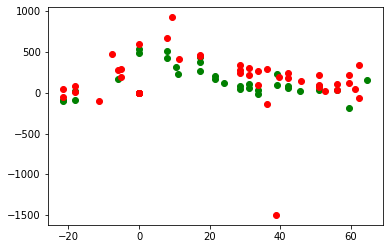

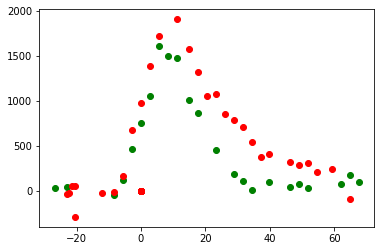

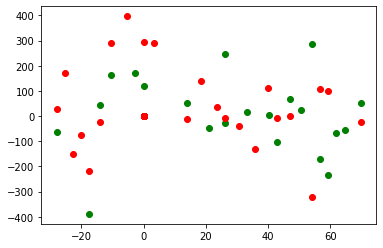

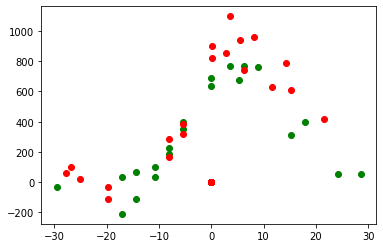

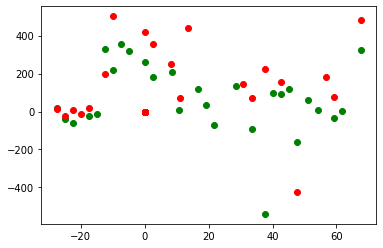

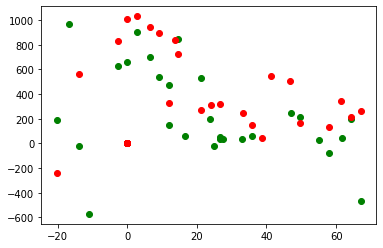

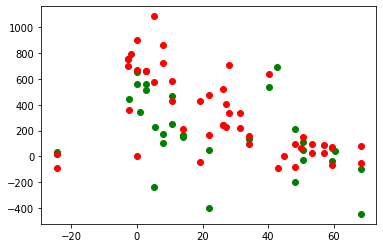

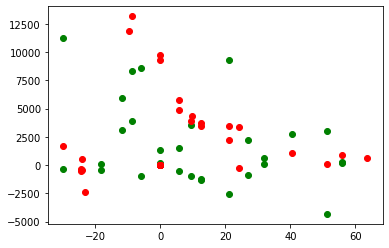

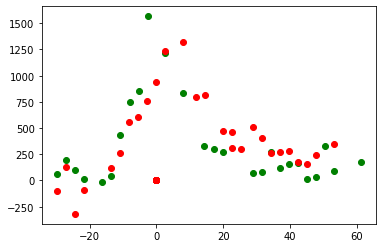

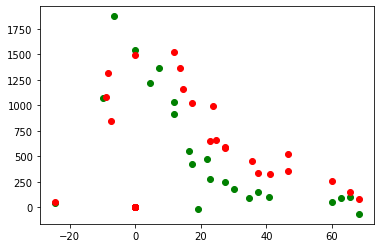

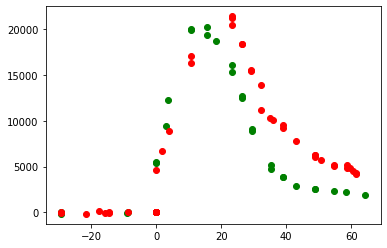

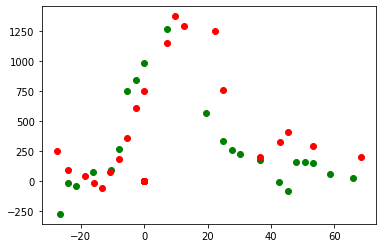

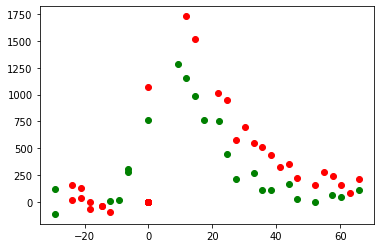

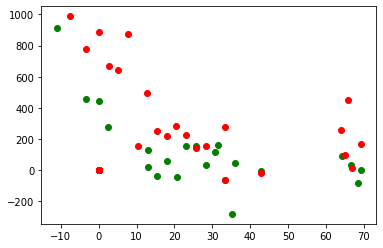

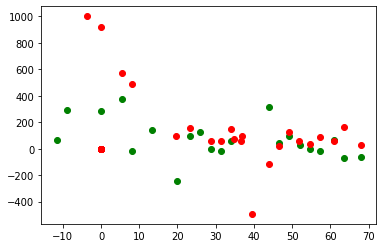

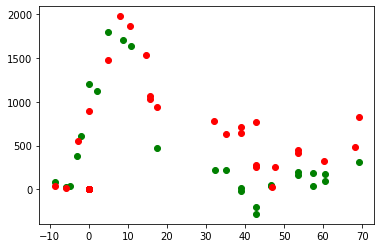

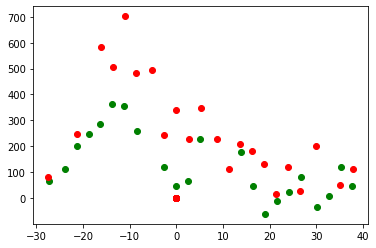

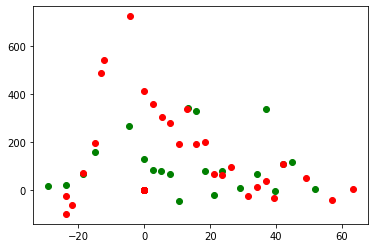

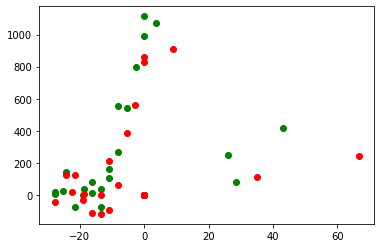

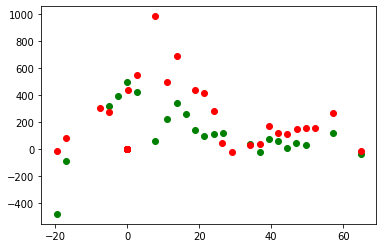

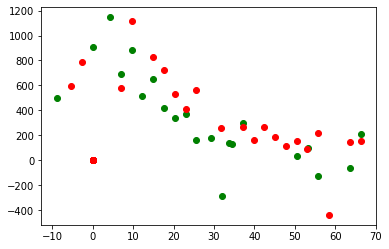

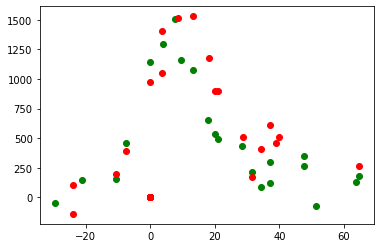

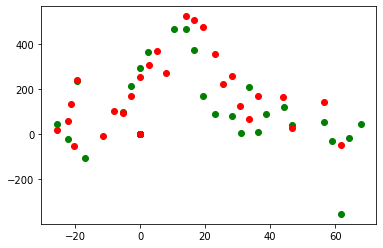

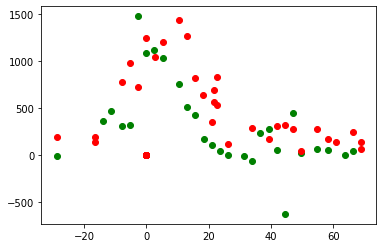

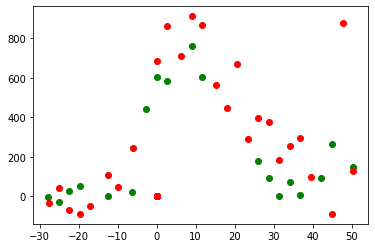

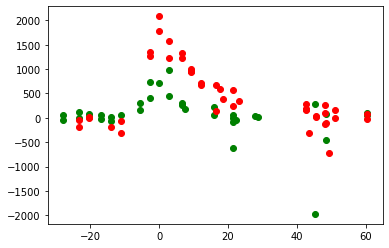

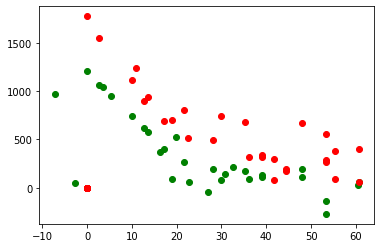

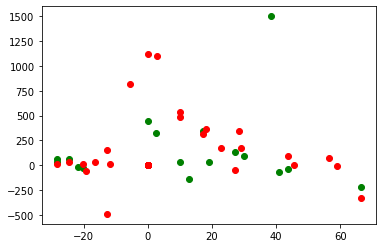

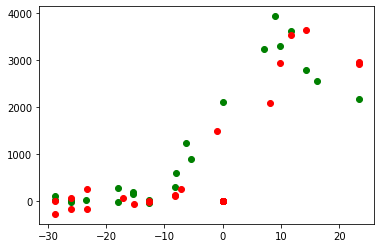

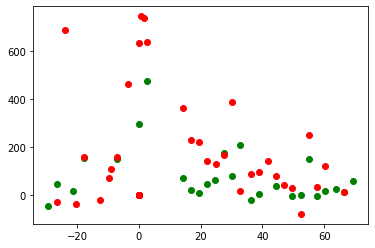

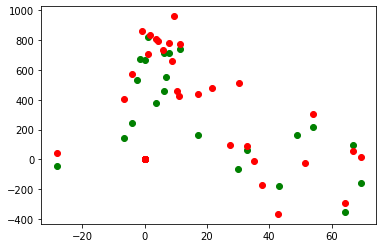

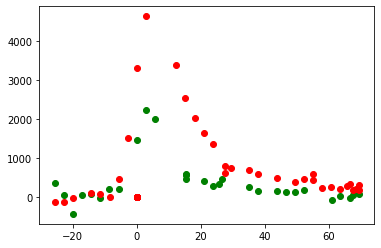

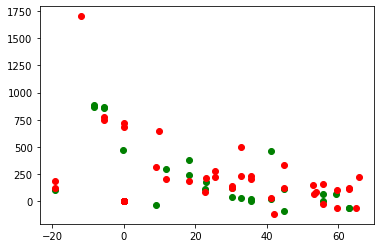

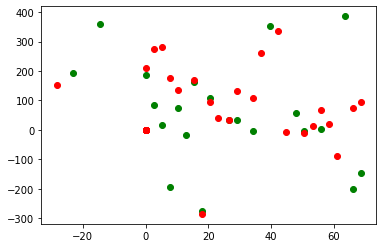

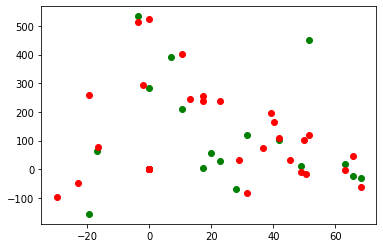

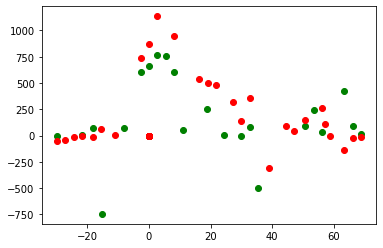

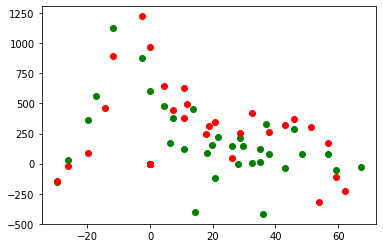

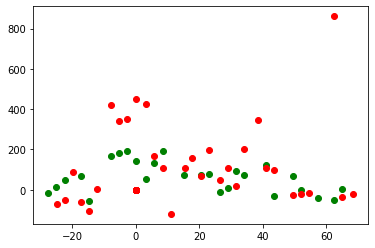

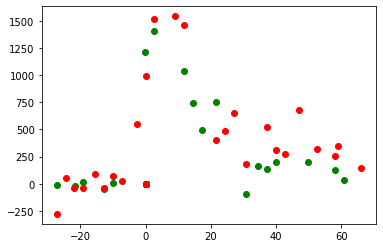

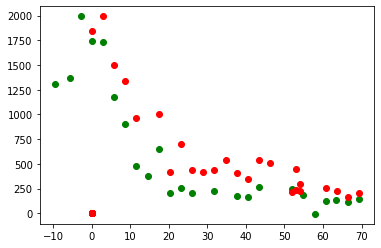

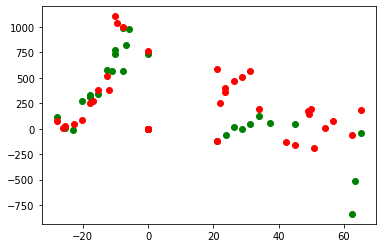

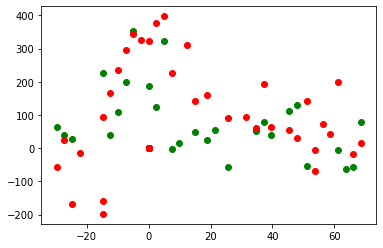

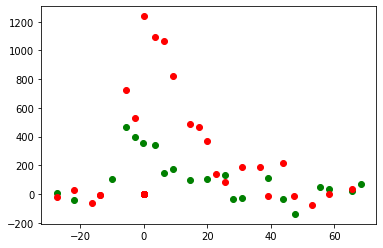

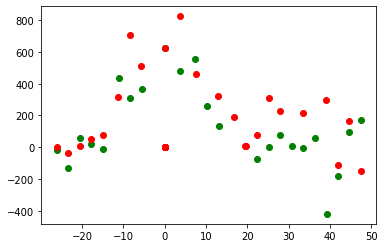

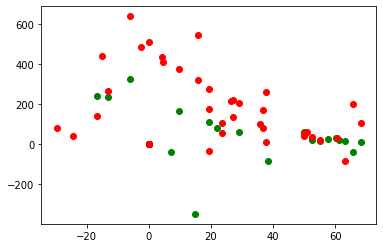

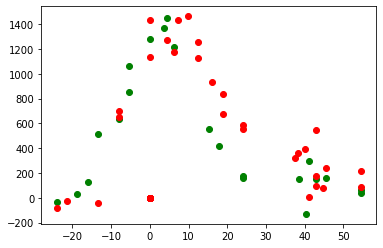

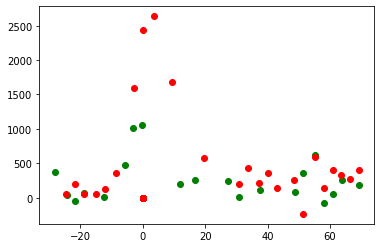

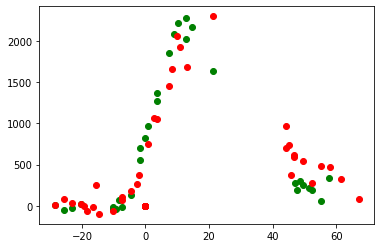

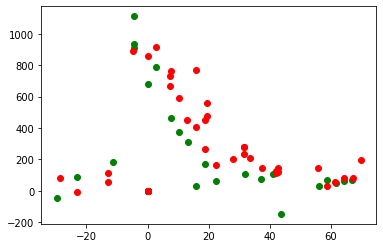

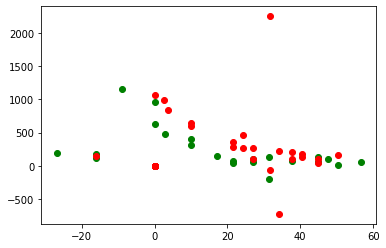

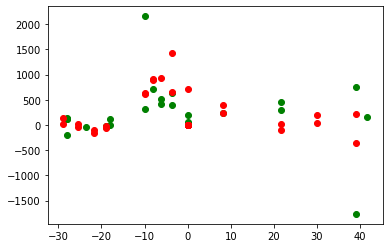

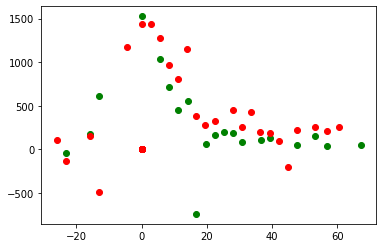

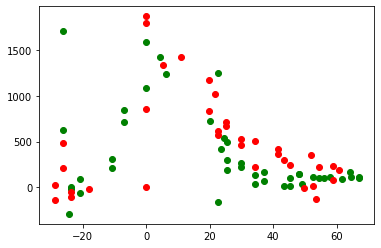

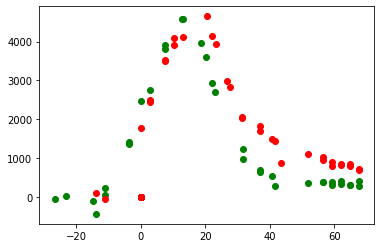

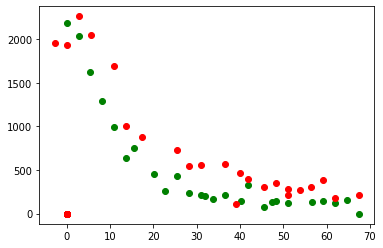

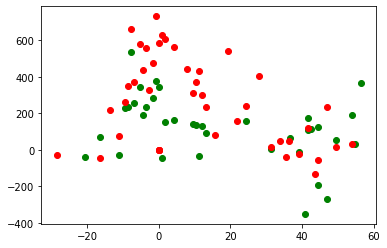

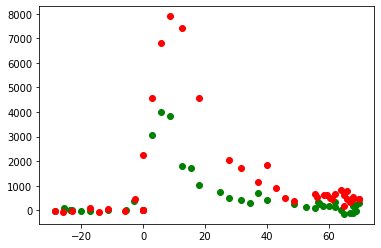

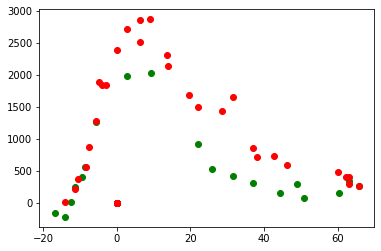

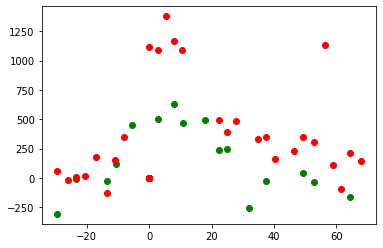

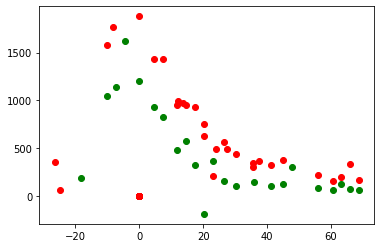

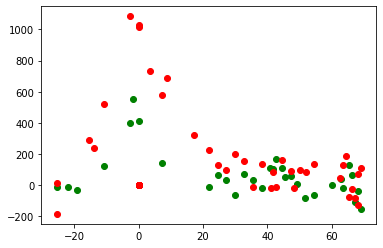

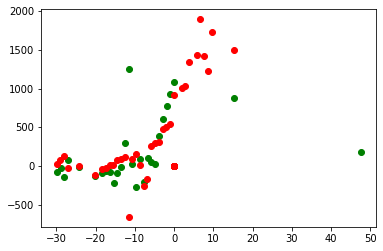

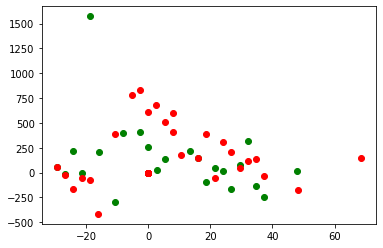

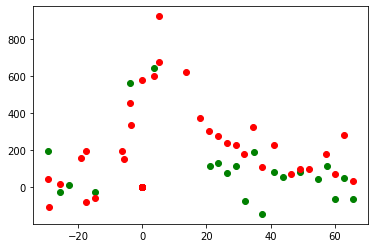

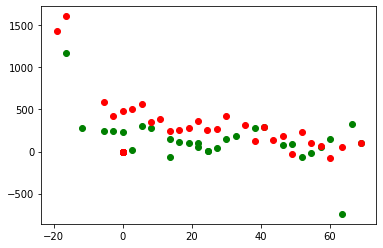

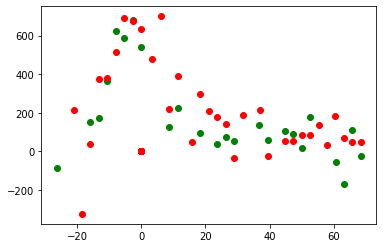

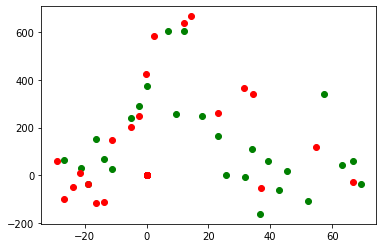

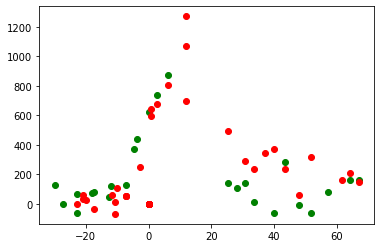

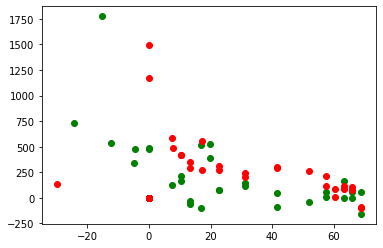

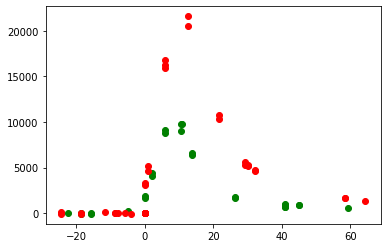

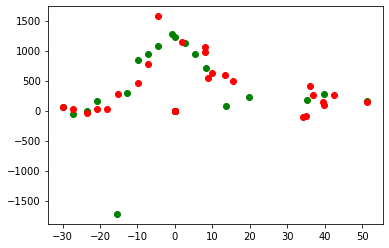

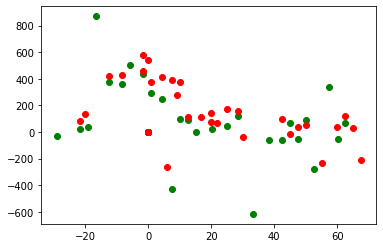

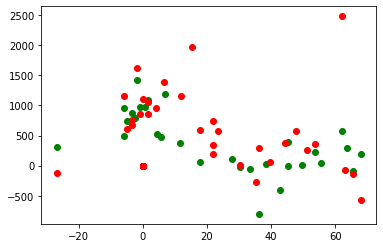

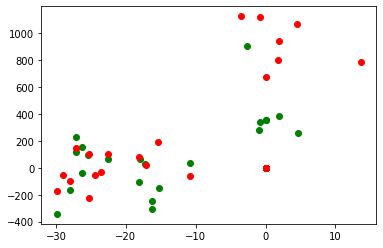

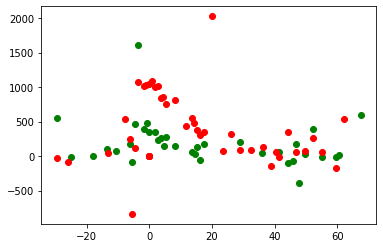

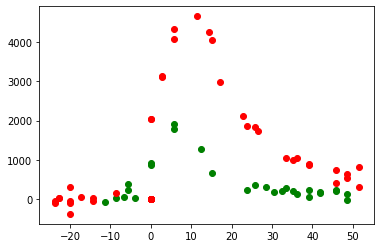

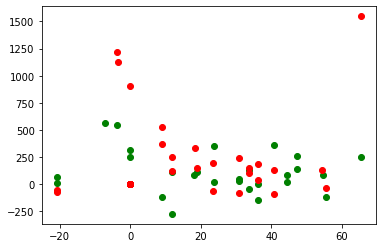

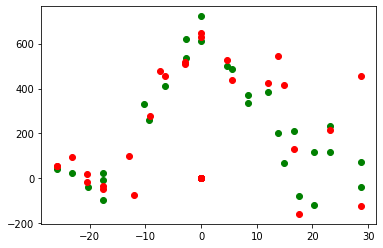

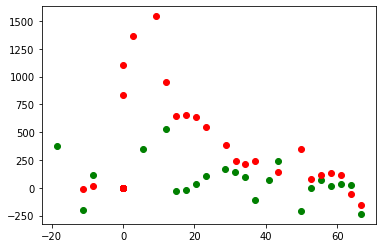

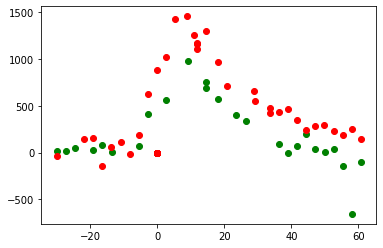

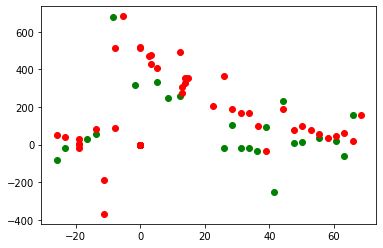

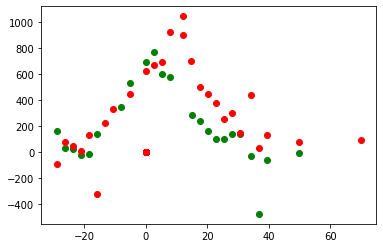

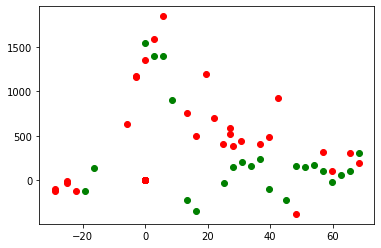

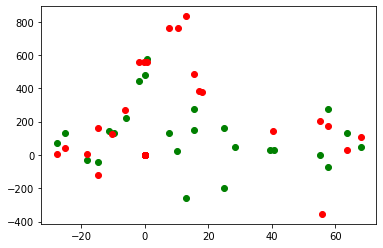

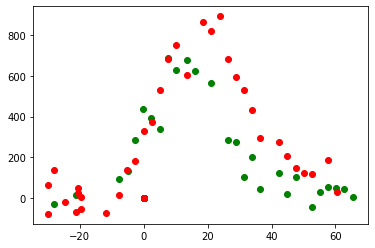

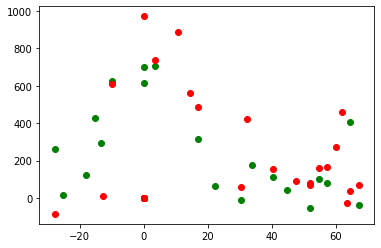

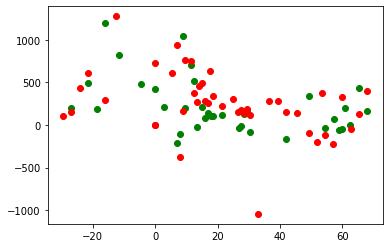

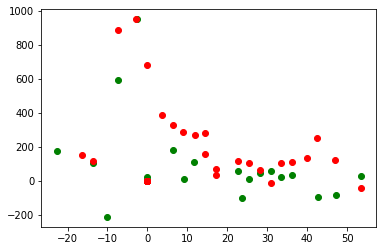

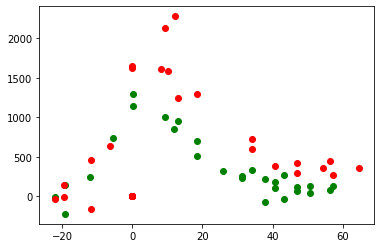

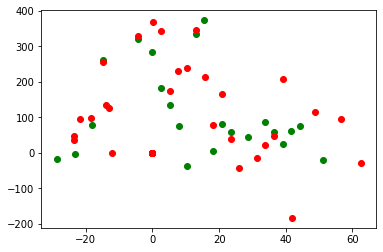

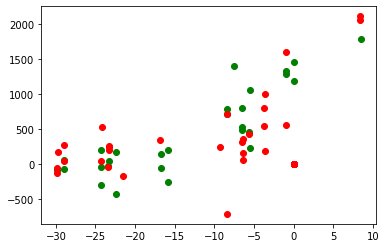

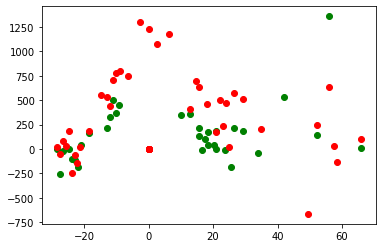

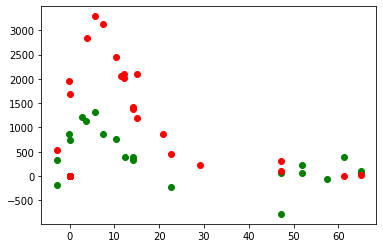

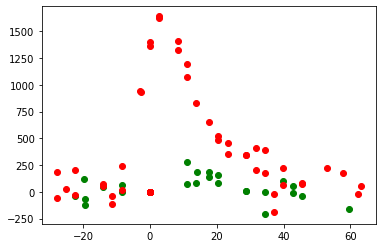

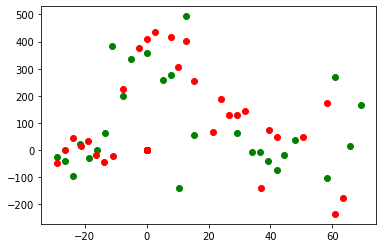

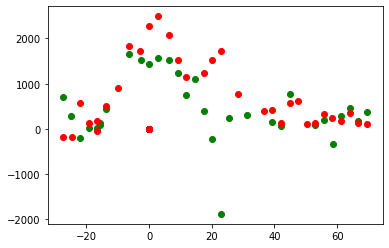

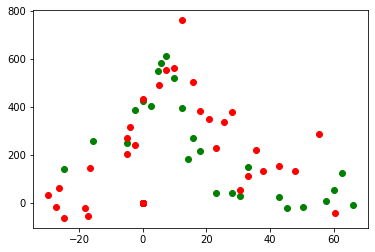

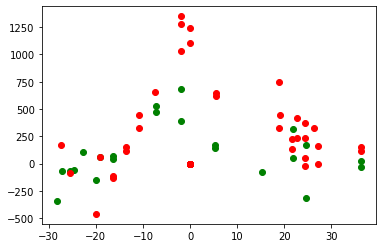

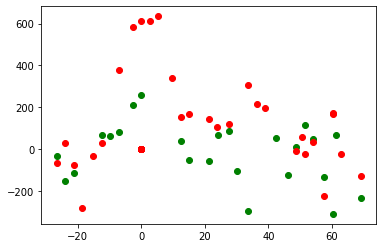

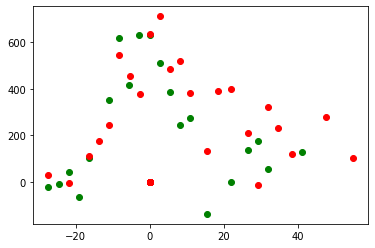

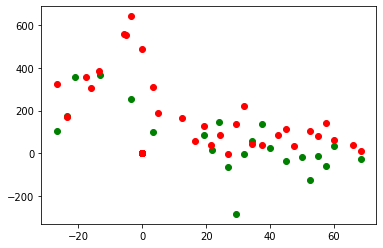

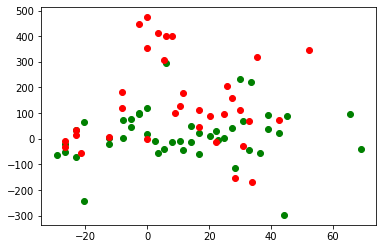

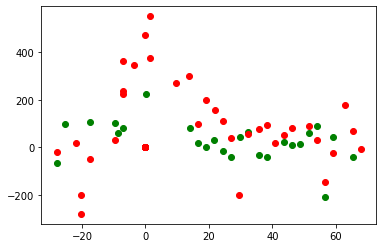

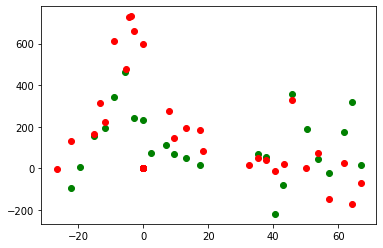

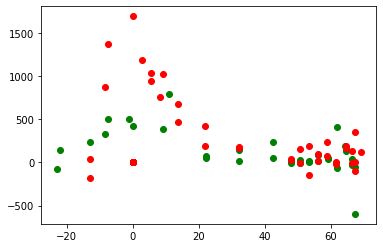

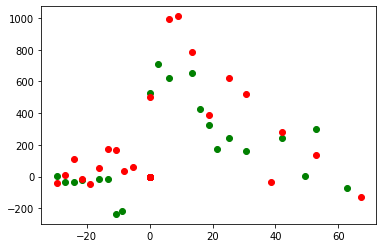

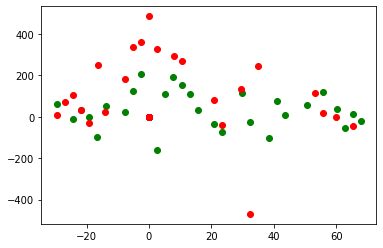

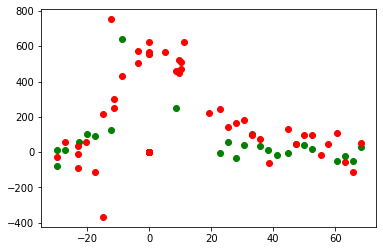

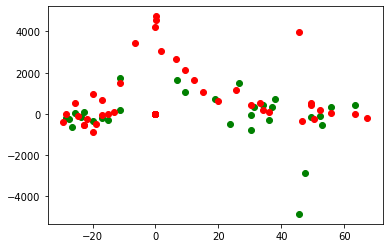

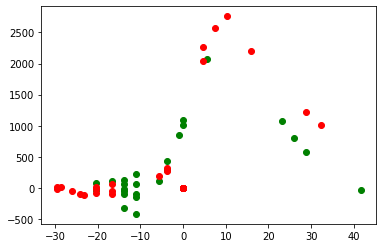

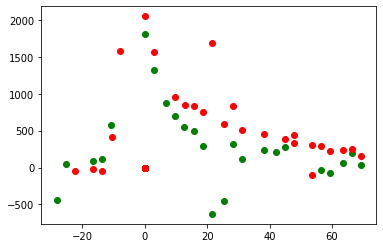

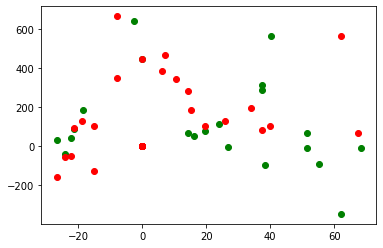

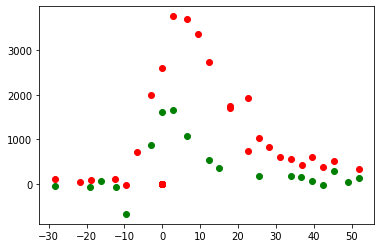

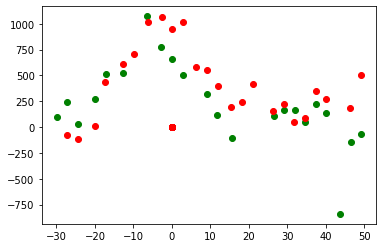

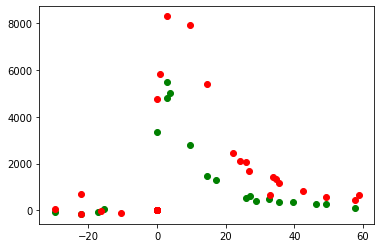

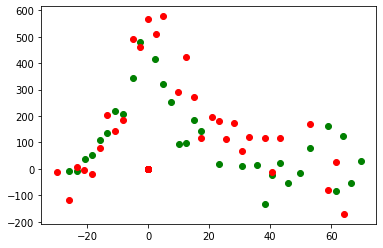

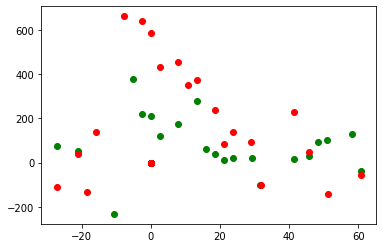

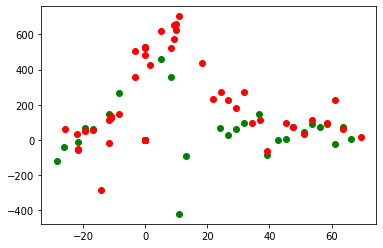

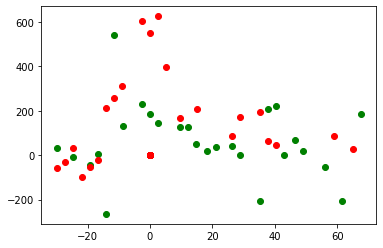

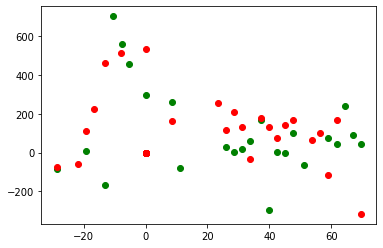

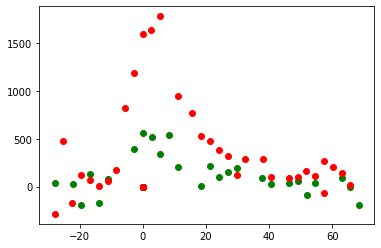

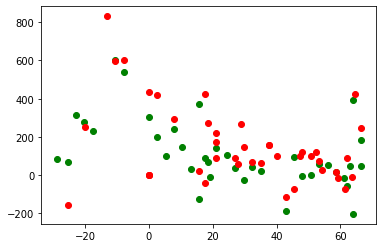

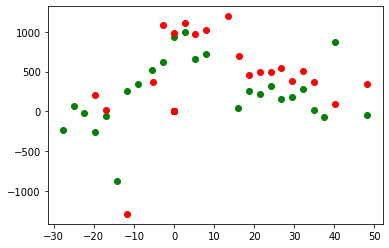

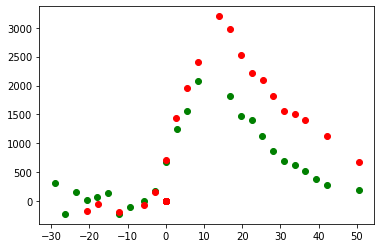

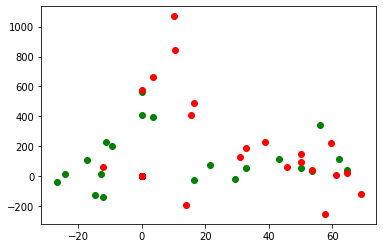

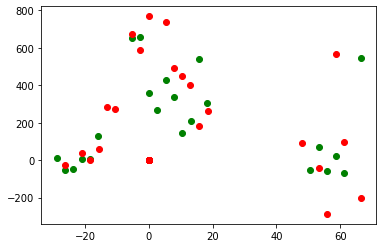

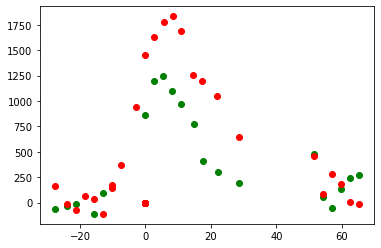

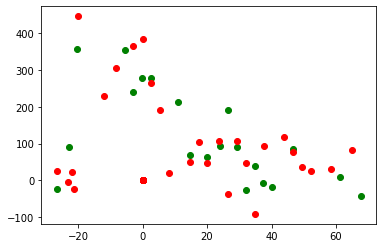

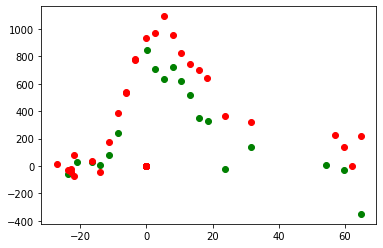

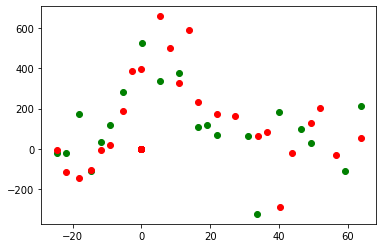

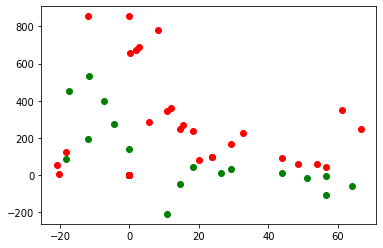

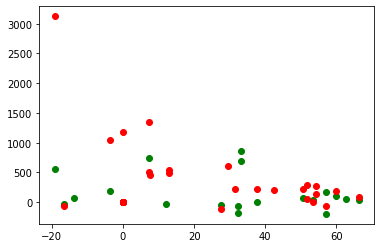

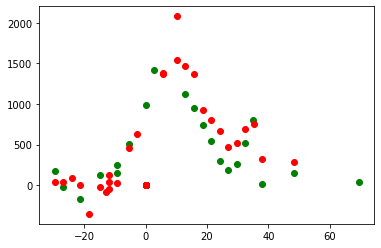

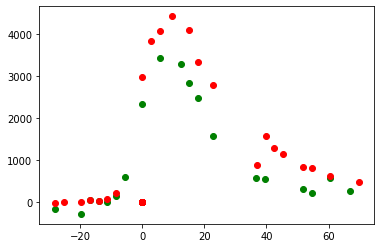

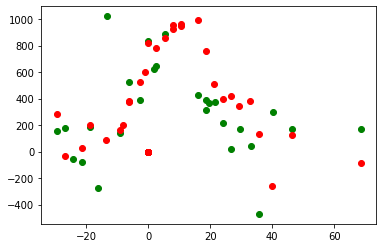

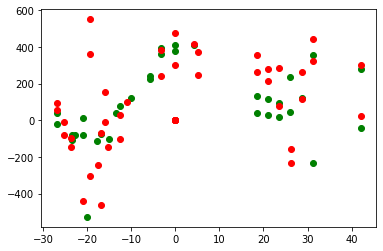

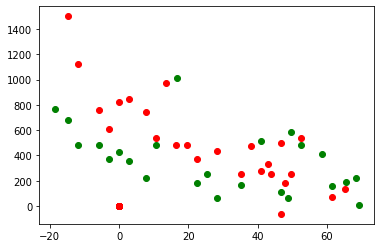

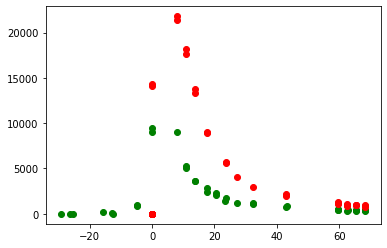

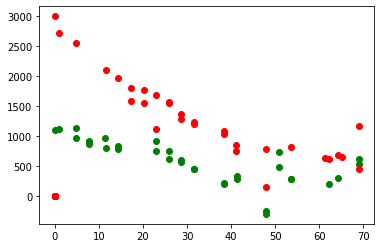

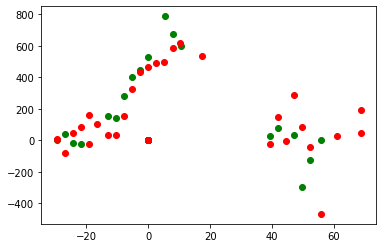

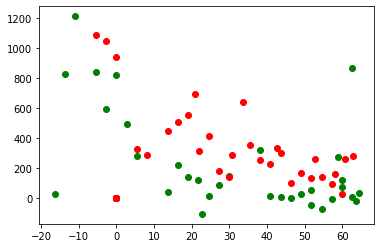

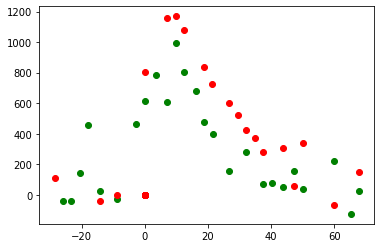

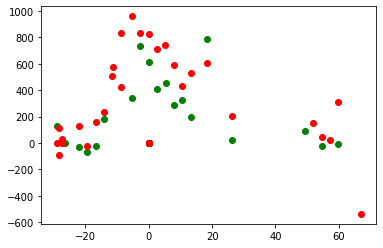

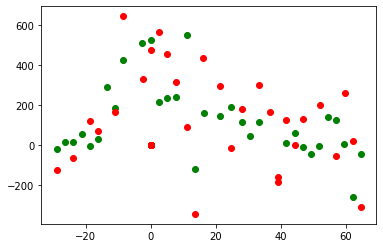

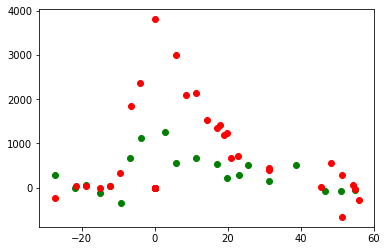

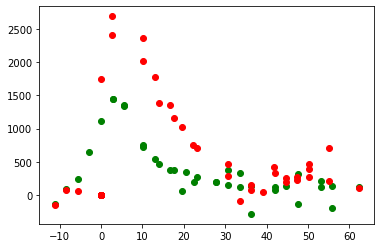

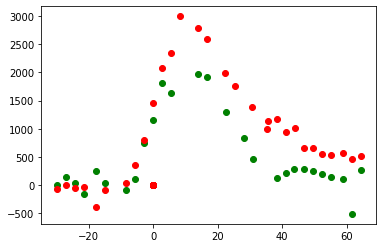

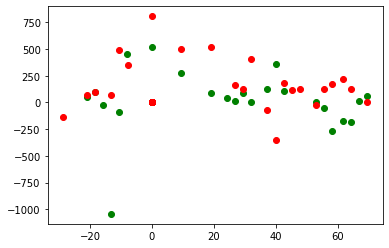

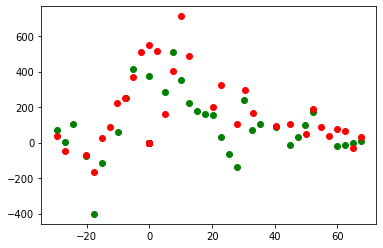

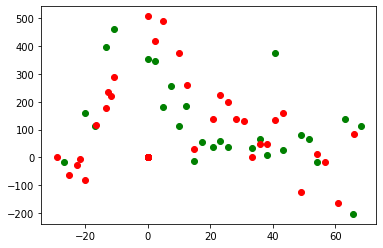

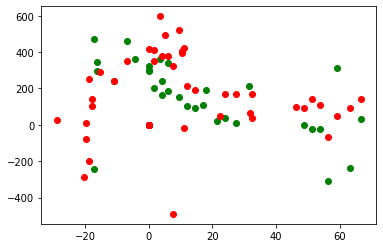

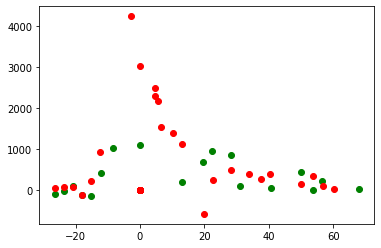

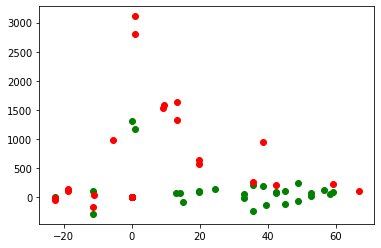

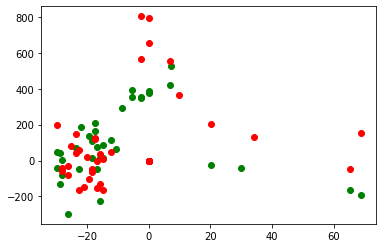

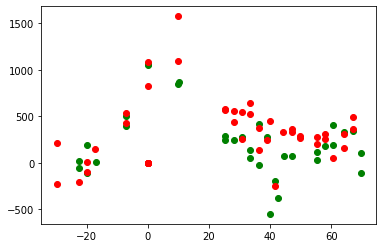

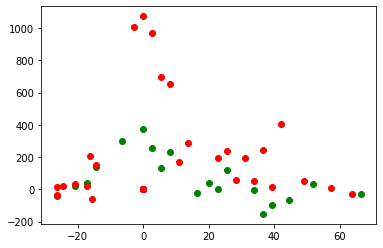

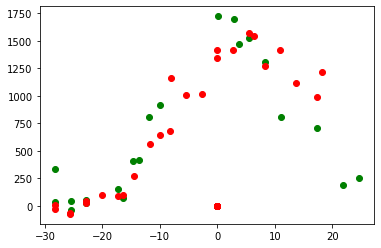

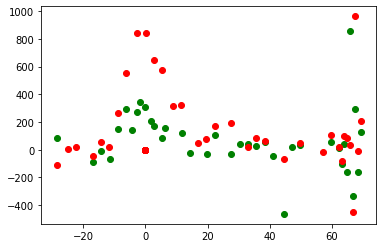

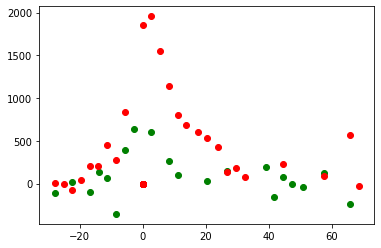

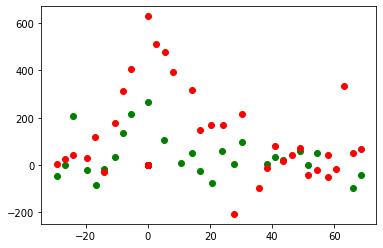

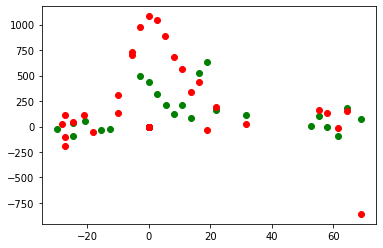

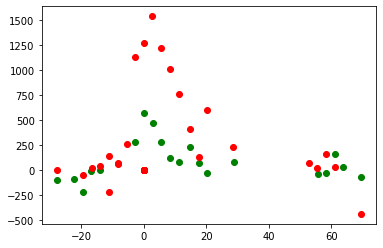

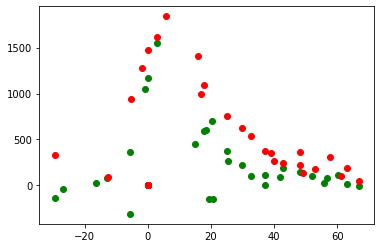

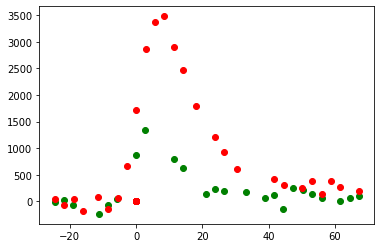

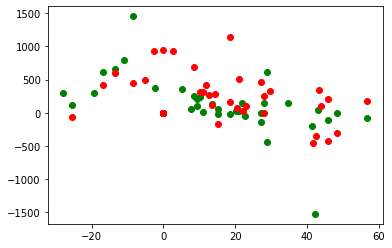

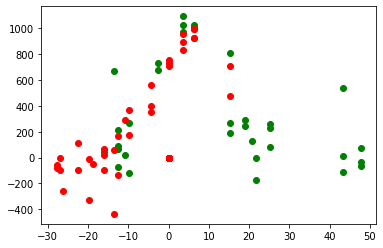

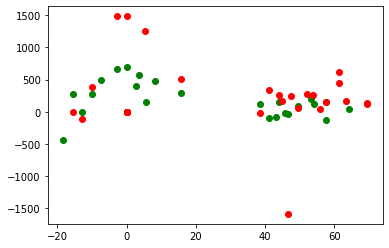

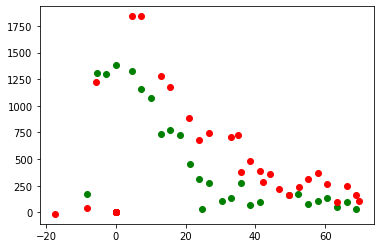

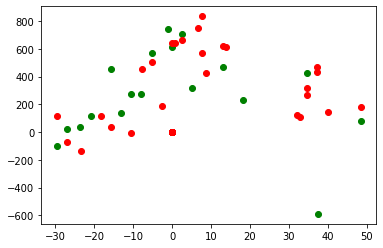

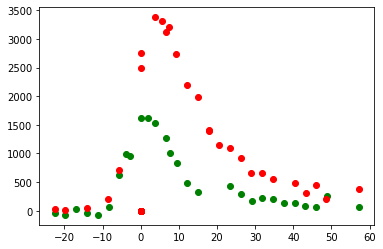

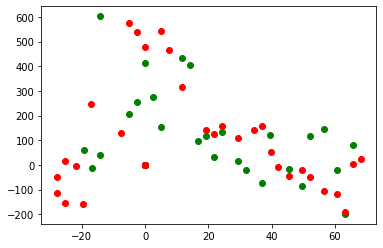

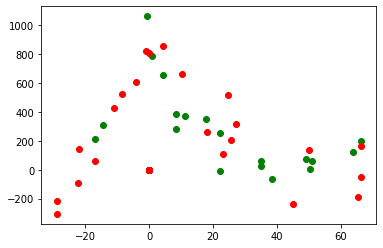

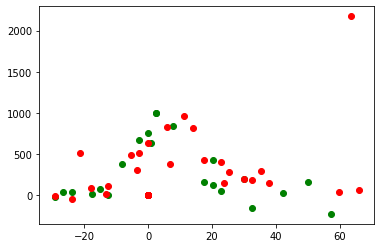

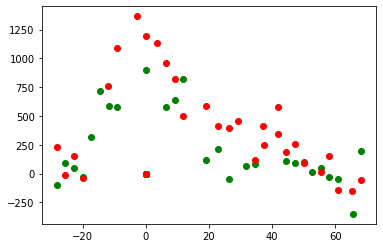

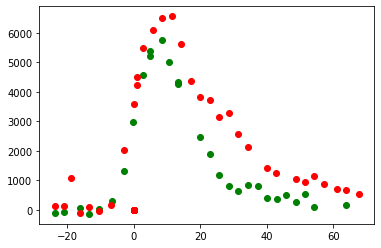

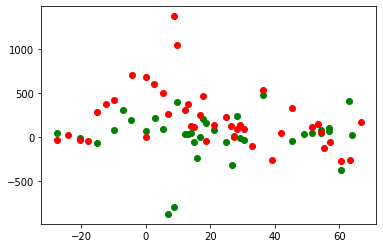

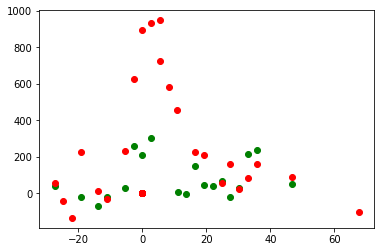

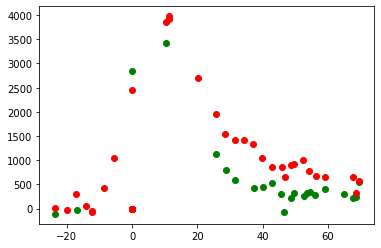

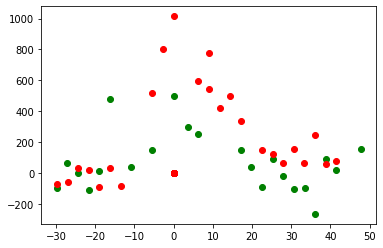

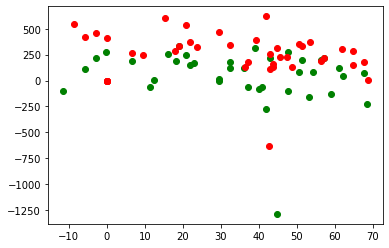

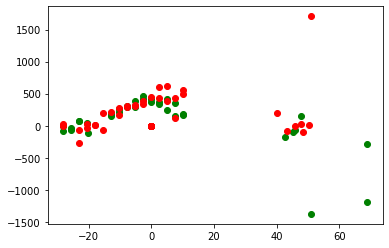

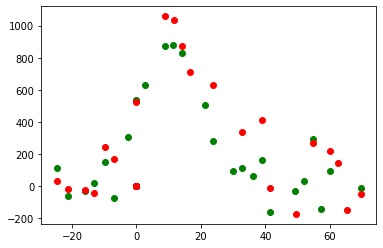

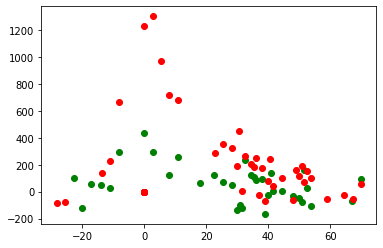

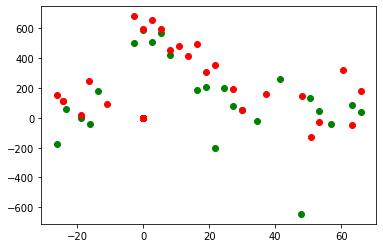

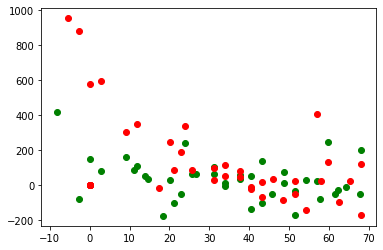

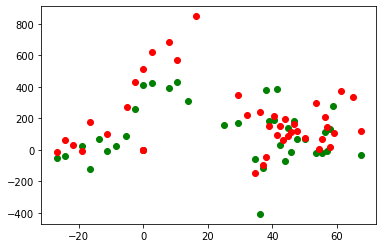

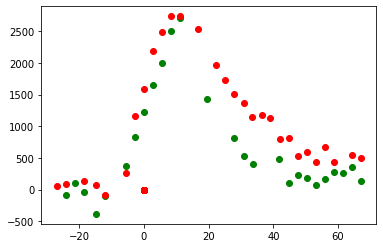

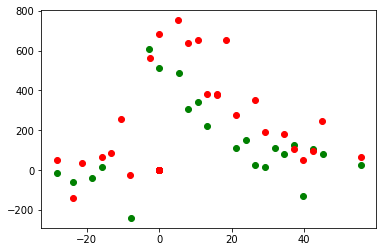

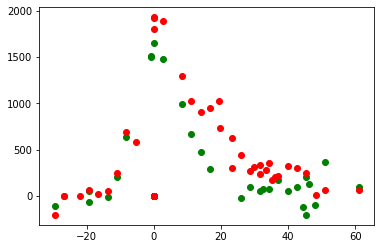

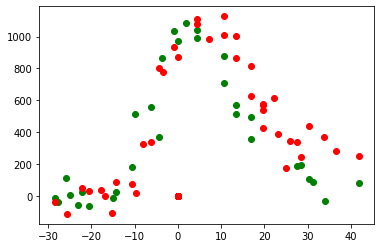

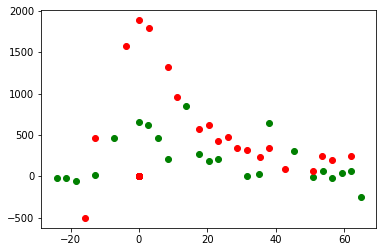

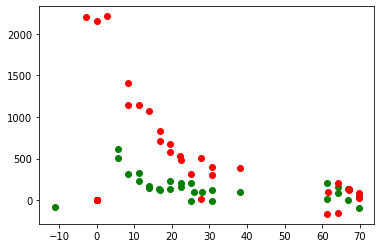

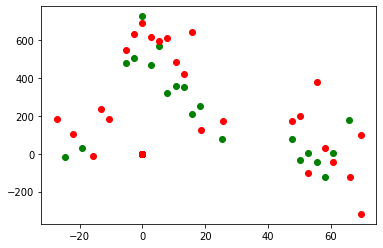

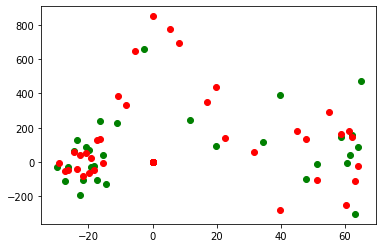

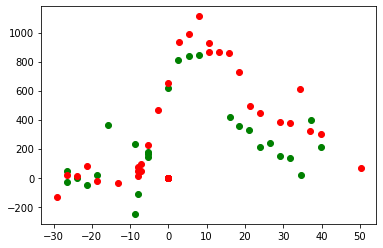

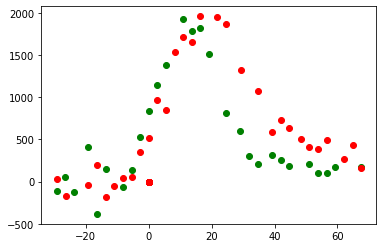

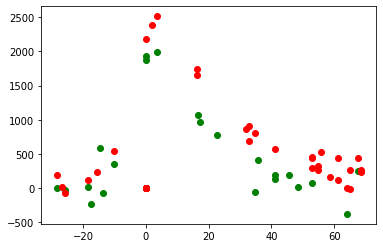

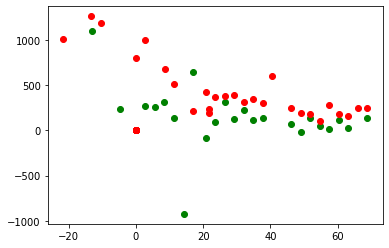

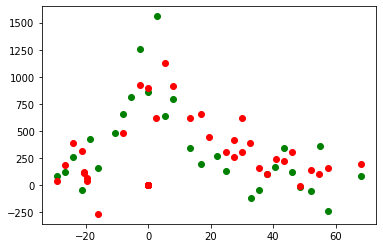

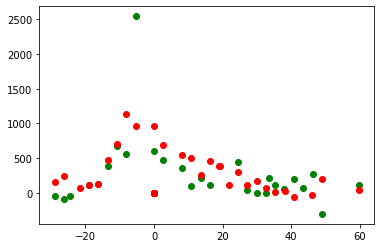

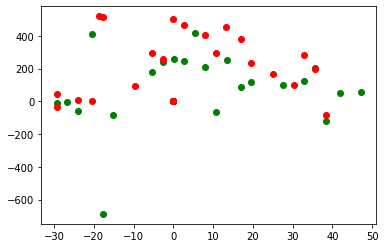

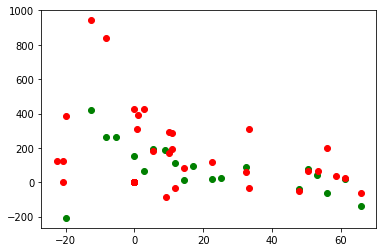

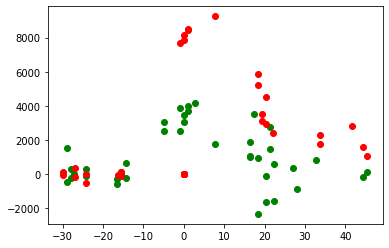

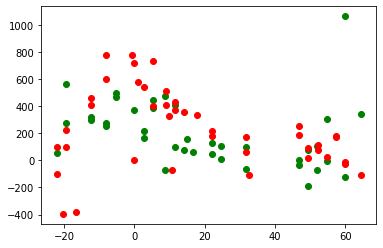

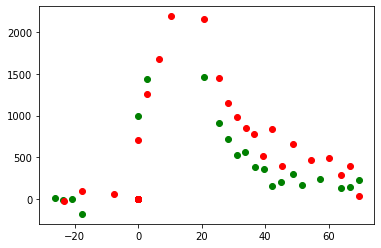

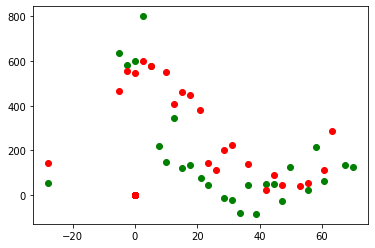

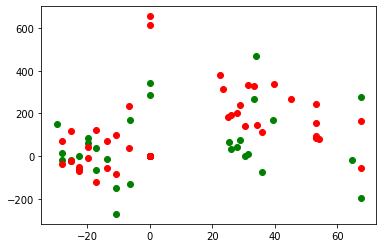

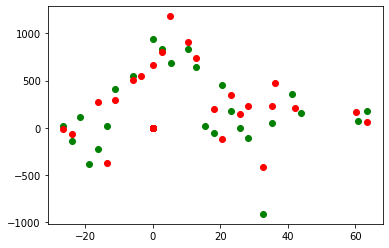

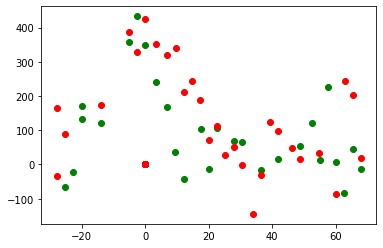

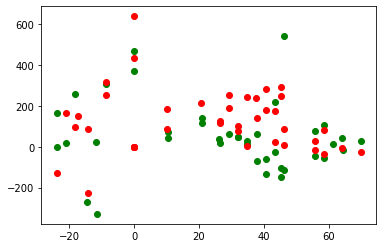

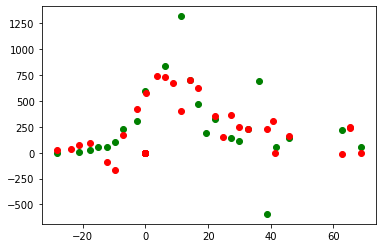

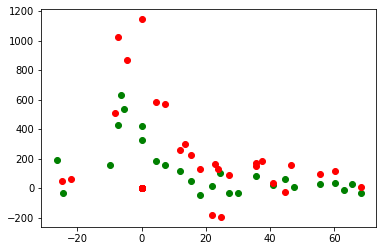

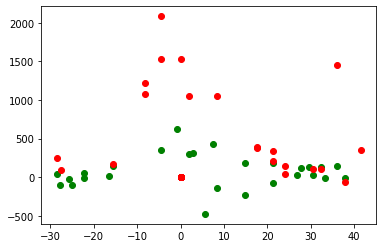

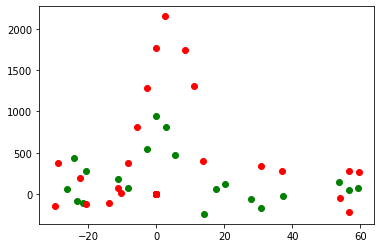

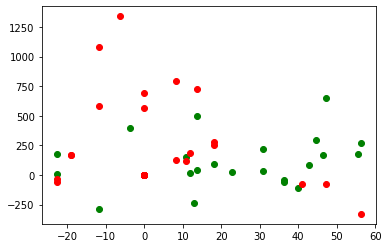

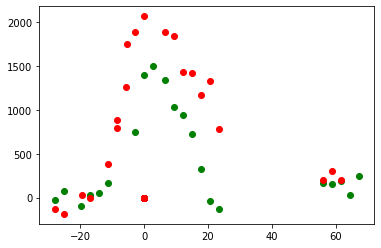

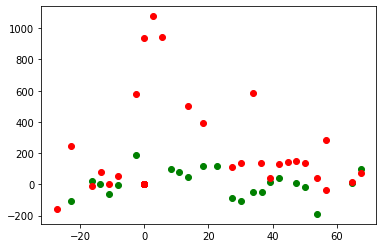

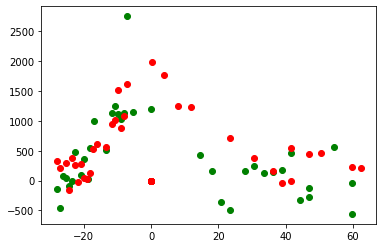

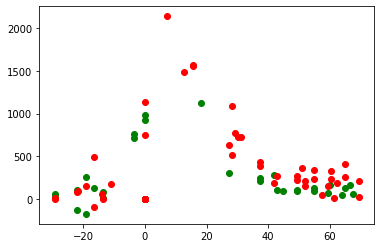

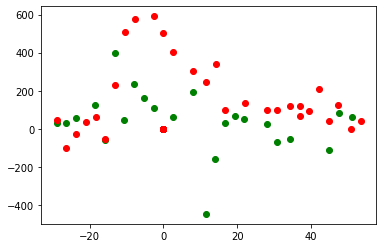

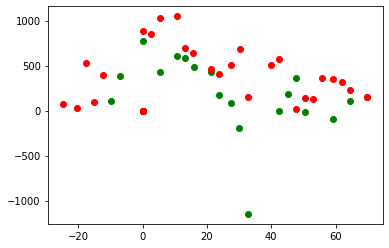

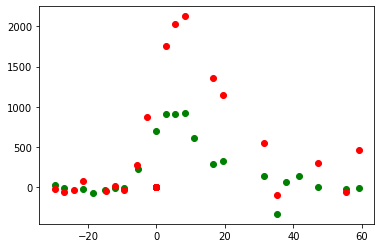

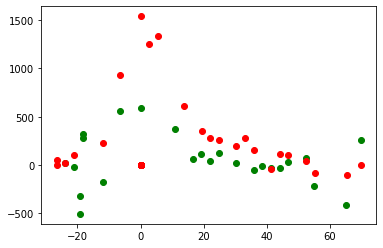

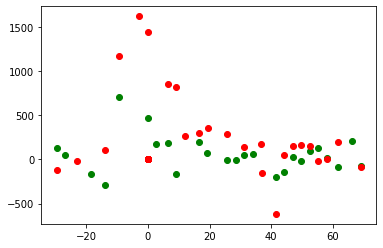

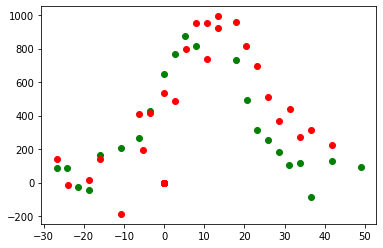

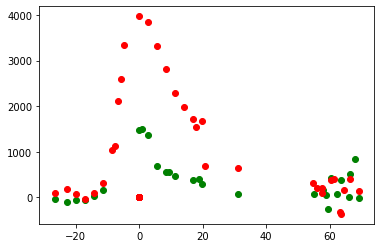

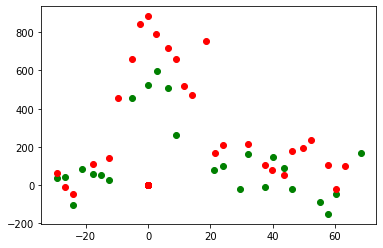

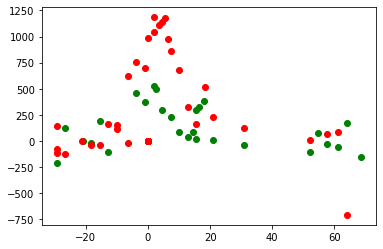

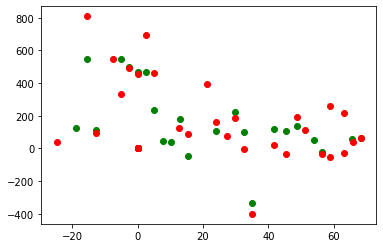

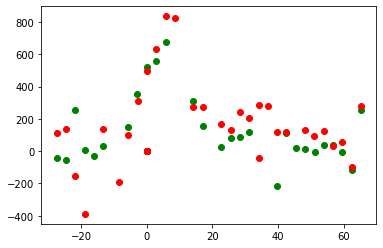

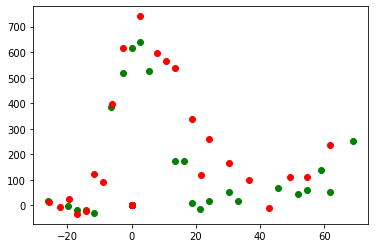

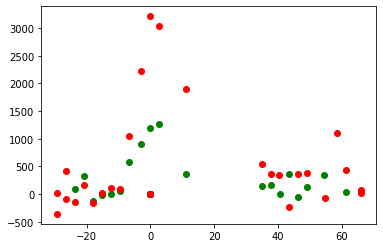

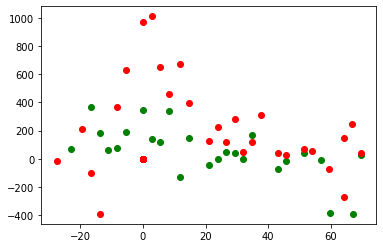

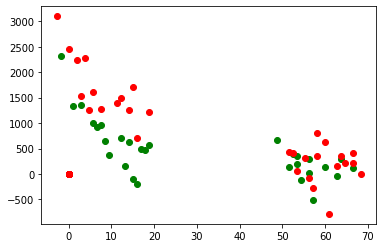

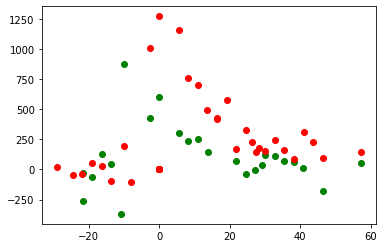

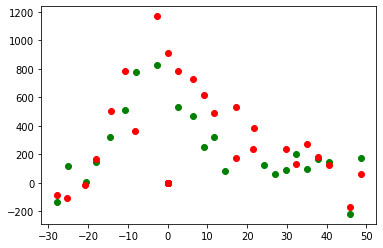

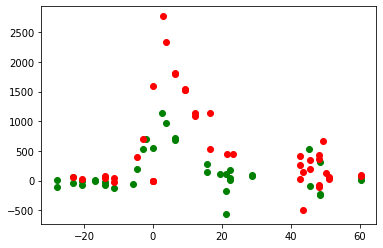

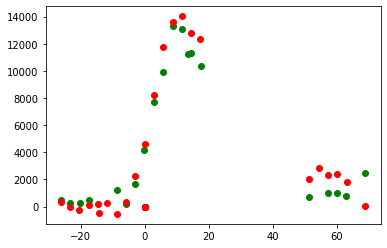

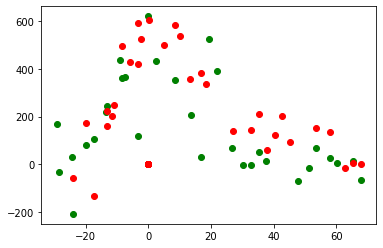

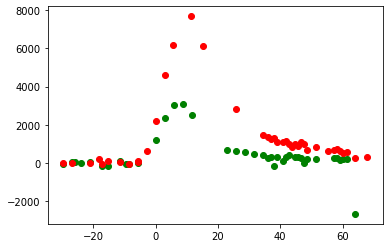

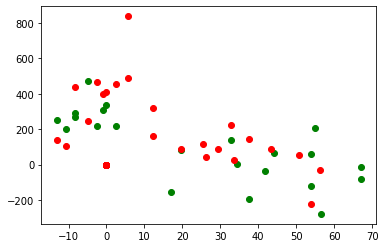

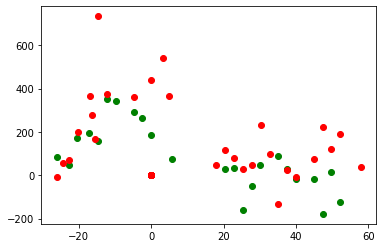

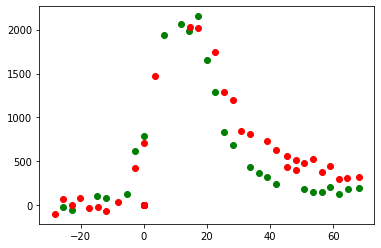

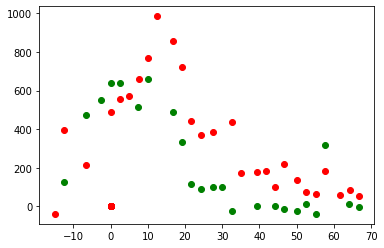

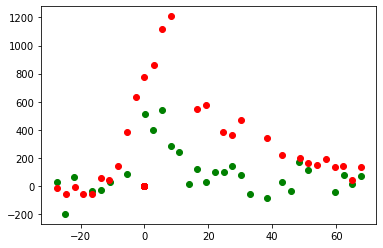

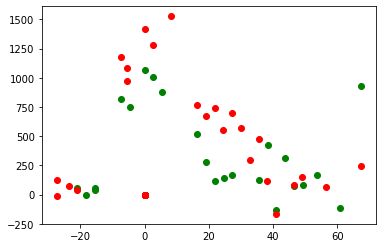

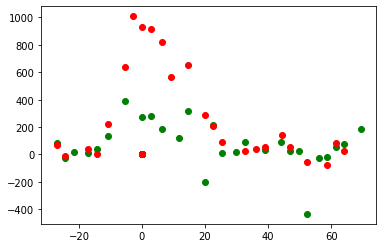

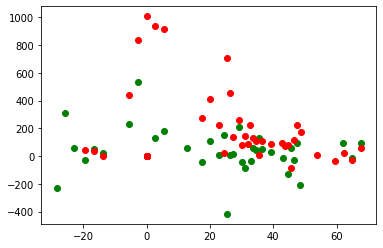

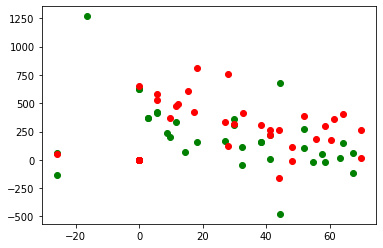

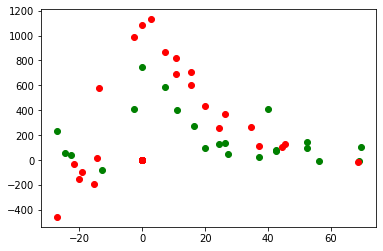

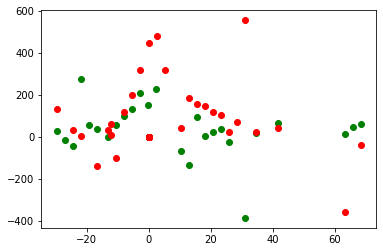

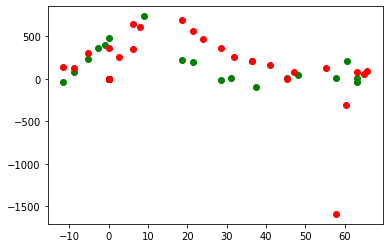

In [ ]:
for light_curve in dataset[:301]:
  r_time = []
  r_flux = []
  g_time = []
  g_flux = []
  # print(light_curve)
  for time, band, flux, error in light_curve:
    # green band
    if band == 4.8:
      g_time.append(time)
      g_flux.append(flux)
    else:
      r_time.append(time)
      r_flux.append(flux)
  # print(r_flux)
  fig, ax1 = plt.subplots(1)
  ax1.scatter(g_time, g_flux, color = 'green')
  ax1.scatter(r_time, r_flux, color = 'red')
  fig.show()

In [ ]:
min, max = None, None
for i, xarr in enumerate(dataset):
    mask = np.where(xarr[:, 2:3] != 0)[0]
    maxval = xarr[:, 2:3][mask].max()
    minval = xarr[:, 2:3][mask].min()
    dataset[i, :, 2:3][mask] = dataset[i, :, 2:3][mask] / (maxval-minval) 
    dataset[i, :, 3:4][mask] = dataset[i, :, 3:4][mask] / (maxval-minval)
    if min is None or minval < min:
      min = minval
    if max is None or maxval > max:
      max = maxval
print(min, max)
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# dataset = scaler.fit(dataset)

-14579.2216796875 91709.1328125


In [ ]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

class Encoder(keras.Model):
  def __init__(self, shapes, mask_val=0, name = 'encoder', **kwargs):
    print("building encoder...")
    super(Encoder, self).__init__(name=name, **kwargs)
    self.mask_val = mask_val
    self.shapes = shapes

    # DEFINE ENCODER LAYERS
    self.enc_input = Input(shape=shapes['enc_input'])

    # get mask for future layer
    self.mask = Masking(mask_value=mask_val)

    # first recurrent layer
    self.gru1 = GRU(shapes['gru1'], activation='tanh', 
                    recurrent_activation='hard_sigmoid', return_sequences=True, name='gru1')
    # second recurrent layer  
    self.encoded = GRU(shapes['gru2'], activation='tanh',
                    recurrent_activation='hard_sigmoid', return_sequences=True, name='gru2')
    
    # z mean output
    self.z_mean = GRU(shapes['gru3'], return_sequences=False, activation='linear', name='gru3')

    # z variance output
    self.z_log_var = GRU(shapes['gru4'], return_sequences=False, activation='linear', name='gru4')

    # sample output
    self.z = Sampling()

  def get_config(self):
      # config = super(Encoder, self).get_config()
      config = {"shapes": self.shapes, 'mask_val':0, 'name':'encoder'}
      return config

  # define forward pass
  def call(self, inputs):
    
    mask_compute = self.mask(inputs)
    gru1 = self.gru1(mask_compute)
    mask_output = self.mask.compute_mask(gru1)

    encoded = self.encoded(gru1)
    z_mean = self.z_mean(encoded)
    z_log_var = self.z_log_var(encoded)
    z = self.z([z_mean, z_log_var])

    return z_mean, z_log_var, z

class Decoder(keras.Model):
  def __init__(self, shapes, mask_val=0, name = 'decoder', **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.mask_val = mask_val
    self.shapes = shapes

    # define layers
    self.decoder_input = Input(shape=shapes['dec_input'])

    self.repeater = RepeatVector(shapes['repeater'], name='rep')

    # time and filter ID vals
    self.input_two = Input(shape=shapes['input_two'])

    # first recurrent layer
    self.gru5 = GRU(shapes['gru5'], activation='tanh',
                    recurrent_activation='hard_sigmoid', return_sequences=True, name='gru5')
    
    # second recurrent layer
    self.gru6 = GRU(shapes['gru6'], activation='tanh',
                    recurrent_activation='hard_sigmoid', return_sequences=True, name='gru6')

    # decoder output
    self.dec_output = TimeDistributed(
        Dense(1, activation='tanh', input_shape=shapes['dec_output']), name='td')

  def get_config(self):
      config = {"shapes": self.shapes, 'mask_val':0, 'name':'decoder'}
      return config

  # define forward pass
  def call(self, inputs):
    z, train_input_two = inputs
    repeater = self.repeater(z)
    concat = concatenate((repeater, train_input_two), axis =-1)
    gru5 = self.gru5(concat)
    gru6 = self.gru6(gru5)
    dec_output = self.dec_output(gru6)

    return dec_output

class VAE(keras.Model):
  def __init__(self, prepared_data, dims=(8000,80,4), name='vae', **kwargs):
    super(VAE, self).__init__(name=name, **kwargs)
    self.epochs = 20
    self.batch_size = 64
    self.optimizer = 'adam'

    # dimension of the latent vector
    self.latent_dim = 30

    # input to first encoder and second decoder layer
    self.gru_one = 175

    # input to first decoder and second encoder layer
    self.gru_two = 150

    # load prepared dad (acts a input)
    self.prepared_data = np.array(prepared_data)
    
    # number of input features
    self.num_feats = dims[2]
    
    # number of timesteps
    self.num_timesteps = dims[1]

    # dimension of the input space for encoder
    self.enc_input_shape = (self.num_timesteps, self.num_feats)

    # number of light curves
    self.num_lcs = dims[0]

    # layer dimensions for encoder and decoder, respectively
    self.enc_dims = {
      'enc_input': self.enc_input_shape,
      'gru1': self.gru_one,
      'gru2': self.gru_two,
      'gru3': self.latent_dim,
      'gru4': self.latent_dim
    }
    self.dec_dims = {
      'dec_input': self.latent_dim,
      'repeater': self.num_timesteps,
      'input_two': (self.num_timesteps, 2),
      'gru5': self.gru_two,
      'gru6': self.gru_one,
      'dec_output': (None, 1)
    }


    # indxs for test and train
    self.train_indx = set()
    self.test_indx  = set()

    self.mask_value = 0.0
    
    self.encoder = Encoder(self.enc_dims)
    self.decoder = Decoder(self.dec_dims)

  def get_config(self):
      config = {"prepared_data": np.array(self.prepared_data), 'name':'vae'}
      return config

  # define forward pass
  def call(self, inputs):
    x_train, train_input_two = inputs
    z_mean, z_log_var, z = self.encoder(x_train)
    reconstructed = self.decoder([z, train_input_two])

    # Add KL divergence regularization loss.
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
    )
    self.add_loss(kl_loss)
    return reconstructed

  def reconstruction_loss(self, yTrue, yPred):
    return K.log(K.mean(K.square(yTrue - yPred)))

  def split_prep_data(self):
      """
      Splits data into 3/4 training, 1/4 testing
      """

      print("Splitting data into train and test...")

      # prepared out (only flux)
      prep_out = self.prepared_data[:, :, 2].reshape(
          self.num_lcs, self.num_timesteps, 1)
      # prep_out = self.prepared_data[:, :, 2]
      # print('prep_out shape', prep_out.shape)
      prep_inp = self.prepared_data

      x_train = []
      y_train = []
      x_test = []
      y_test = []

      # calc the # of light curves for train vs test
      num_lcs = len(prep_inp)
      train_perc = round(1.0 * num_lcs)
      test_perc = round(num_lcs*0.2)

      # save random indices for training
      while len(self.train_indx) != train_perc:
          indx = random.randint(0, num_lcs-1)
          self.train_indx.add(indx)

      # save random indices for testint -> no duplicates from training
      while len(self.test_indx) <= test_perc:
          indx = random.randint(0, num_lcs-1)
          # if indx not in self.train_indx:
          self.test_indx.add(indx)

      # extract training data
      for ind in self.train_indx:
          x_train.append(prep_inp[ind])
          y_train.append(prep_out[ind])

      # extract testing data
      for ind in self.test_indx:
          x_test.append(prep_inp[ind])
          y_test.append(prep_out[ind])

      # change to numpy arrays
      x_train = np.array(x_train).astype(np.float64)
      x_test = np.array(x_test).astype(np.float64)
      y_train = np.array(y_train).astype(np.float64)
      y_test = np.array(y_test).astype(np.float64)

      print('shape of prep_inp and x_train:', prep_inp.shape, x_train.shape)
      print('shape of prep_out and y_train:', prep_out.shape, y_train.shape)

      return x_train, x_test, y_train, y_test

  def train_model(self, x_train, x_test, y_train, y_test):
      """
      Trains the NN on training data

      Returns the trained model.
      """
      # fit model
      train_inp_two = x_train[:, :, :2]
      assert (train_inp_two.shape == (
          x_train.shape[0], x_train.shape[1], 2))

      test_inp_two = x_test[:, :, :2]
      assert (test_inp_two.shape == (
          x_test.shape[0], x_test.shape[1], 2))

      print('fitting model...')
      history = self.fit([x_train, train_inp_two], y_train, epochs=self.epochs, batch_size=self.batch_size,
                          validation_data=([x_test, test_inp_two], y_test), verbose=1, shuffle=False)

      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()

  def test_model(self, x_test, y_test, amount = None):
      """
      Uses test data to and NN to predict light curve decodings.

      Plots reconstructed light curved from the model prediction vs the orignal curve.
      """
      if amount:
        indices = random.sample(range(len(x_test)), k=amount)
        x_test = np.array([x_test[i] for i in indices])
        y_test = np.array([y_test[i] for i in indices])
      

      test_inp_two = x_test[:, :, :2]

      print('test_inp_one shape: ', x_test.shape)
      print('test_inp_two shape: ', test_inp_two.shape)

      self.summary()

      print('predicting...')
      for i in tqdm(range(len(x_test))):

          # predicted flux
          predicted = self.predict([x_test[i].reshape(-1, self.num_timesteps, 4),
                                    test_inp_two[i].reshape(-1, self.num_timesteps, 2)])[0]

          # if first prediction, print the prediction
          if i == 0:
              print('shape of predicted data: ', predicted.shape)

          self.plot_band_pred(y_test[i], predicted, i, test_inp_two[i])

      print("done predicting")

  def plot_true_pred(self, raw, pred, num):
      """
      Plots true lightcurves vs their decodings by the NN
      """

      # make 1 x 2 figure
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.suptitle('True vs Decoded Light Curves: ' + str(light_curve_names[num]))

      raw_flux = raw[:, 0]
      raw_flux = raw_flux[raw_flux != 0.0]

      pred_flux = pred
      pred_flux = pred_flux[:len(raw_flux)]
      # print(raw_flux)
      # print(pred_flux)

      pred_time = range(len(pred_flux))
      raw_time = range(len(raw_flux))

      # plot raw data
      ax1.plot(raw_time, raw_flux)
      ax1.set_title('true light curve')

      # plot predicted data
      ax2.plot(pred_time, pred_flux)
      ax2.set_title('predicted light curve')

      # save image
      fig.show()

  def plot_band_pred(self, raw, pred, num, time_filters):


      raw_g_flux    = []
      raw_r_flux    = []
      raw_tess_flux = []

      pred_g_flux    = []
      pred_r_flux    = []
      pred_tess_flux = []

      g_time    = []
      r_time    = []
      tess_time = []
      # print(time_filters)
      for i in range(len(time_filters)):
        time, filter_ID = time_filters[i]
        raw_flux  = raw[i, 0]
        pred_flux = pred[i, 0]
        if filter_ID == 4.8:
          raw_g_flux.append(raw_flux)
          pred_g_flux.append(pred_flux)
          g_time.append(time)
        elif filter_ID == 6.5:
          raw_r_flux.append(raw_flux)
          pred_r_flux.append(pred_flux)
          r_time.append(time)
        elif filter_ID == 7.9:
          raw_tess_flux.append(raw_flux)
          pred_tess_flux.append(pred_flux)
          tess_time.append(time)

      # plot
      # make 1 x 2 figure
      fig, (ax1, ax2) = plt.subplots(2, sharey = True)
      fig.suptitle('True vs Decoded Light Curves: ' )#+ str(light_curve_names[num]))

      # pred_time = range(len(pred_flux))
      # raw_time = range(len(raw_flux))

      # plot raw data
      ax1.scatter(g_time, raw_g_flux, label='g-band', color = 'green')
      ax1.scatter(r_time, raw_r_flux, label='r-band', color = 'red')
      ax1.scatter(tess_time, raw_tess_flux, label='tess-band')
      ax1.set_ylabel('actual')

      # plot predicted data
      ax2.set_ylabel('predicted')
      ax2.scatter(g_time, pred_g_flux, label='g-band', color='green')
      ax2.scatter(r_time, pred_r_flux, label='r-band', color='red')
      ax2.scatter(tess_time, pred_tess_flux, label='tess-band')
      # save image
      fig.show()
      fig.savefig(path_to_module + "light_curve_plots/" + str(num) + ".png")
      files.download(path_to_module + "light_curve_plots/" + str(num) + ".png")
      


  def t_SNE_plot(self, light_curves, encoder):
      """
      Constructs 2D plots of light curves in latent space.
      """
      print('using t-SNE...')

      # extract all class outputs and inputs
      labels = np.array([c.loc[0, 'Class']
                        for c in light_curves if c.loc[0, 'Class'] != 3])

      # extract all training label indexes
      indxs = [i for i in range(len(labels)) if labels[i] != 3]

      labeled_data = np.array([self.prepared_data[i] for i in indxs])

      _, _, z = tqdm(encoder.predict(labeled_data))

      t_sne = TSNE(n_components=2, learning_rate='auto',
                    init='random').fit_transform(z)
      print('t-sne shape: ', t_sne.shape)

      plt.figure(figsize=(12, 10))
      plt.scatter(t_sne[:, 0], t_sne[:, 1], c=labels)
      plt.colorbar()
      plt.title("t-SNE with only labeled data")
      plt.show()

      # include unlabeled data
      labels = np.array([c.loc[0, 'Class'] for c in light_curves])
      data = self.prepared_data

      _, _, z = tqdm(encoder.predict(data))

      t_sne = TSNE(n_components=2, learning_rate='auto',
                    init='random').fit_transform(z)
      print('t-sne shape: ', t_sne.shape)

      plt.figure(figsize=(12, 10))
      plt.scatter(t_sne[:, 0], t_sne[:, 1], c=labels)
      plt.colorbar()
      plt.title("t-SNE with labeled and unlabeled data")
      #plt.savefig(self.filepath+'plots/unlabeled-t-sne-latent-space.png', facecolor='white')
      plt.show()

  

In [ ]:
vae = VAE(dataset, dataset.shape)

building encoder...


In [ ]:
# print(vae.prepared_data.shape)
x_train, x_test, y_train, y_test = vae.split_prep_data()
check_pt_path = path_to_module + "chck_pts_sim/separated_classes/"

# training loop:
# after training model for 20 epochs, save it. Do this 25 iterations to train for 500 epochs
print(vae.enc_dims)
print(vae.dec_dims)
optimizer = tf.keras.optimizers.Adam(clipvalue = 1.0)
vae.compile(optimizer=optimizer, loss = vae.reconstruction_loss)
for check_pt_numb in range(8, 11):
  vae.train_model(x_train, x_test, y_train, y_test)
  vae.save(check_pt_path + 'ckpt_' + str(check_pt_numb))


Splitting data into train and test...
shape of prep_inp and x_train: (8000, 80, 4) (8000, 80, 4)
shape of prep_out and y_train: (8000, 80, 1) (8000, 80, 1)
{'enc_input': (80, 4), 'gru1': 175, 'gru2': 150, 'gru3': 30, 'gru4': 30}
{'dec_input': 30, 'repeater': 80, 'input_two': (80, 2), 'gru5': 150, 'gru6': 175, 'dec_output': (None, 1)}
fitting model...
Train on 8000 samples, validate on 1601 samples
Epoch 1/20
8000/8000 [==============================] - 174s 22ms/sample - loss: -4.5545 - val_loss: -4.5353
Epoch 2/20
8000/8000 [==============================] - 164s 21ms/sample - loss: -4.5759 - val_loss: -4.5362
Epoch 3/20
8000/8000 [==============================] - 162s 20ms/sample - loss: -4.5680 - val_loss: -4.5275
Epoch 4/20
8000/8000 [==============================] - 163s 20ms/sample - loss: -4.5695 - val_loss: -4.5183
Epoch 5/20
8000/8000 [==============================] - 163s 20ms/sample - loss: -4.5767 - val_loss: -4.5305
Epoch 6/20
8000/8000 [==============================] 

KeyboardInterrupt: ignored

8000 80
Splitting data into train and test...
shape of prep_inp and x_train: (8000, 80, 4) (8000, 80, 4)
shape of prep_out and y_train: (8000, 80, 1) (8000, 80, 1)
test_inp_one shape:  (40, 80, 4)
test_inp_two shape:  (40, 80, 2)
Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  274935    
                                                                 
 decoder (Decoder)           multiple                  254651    
                                                                 
Total params: 529,586
Trainable params: 529,586
Non-trainable params: 0
_________________________________________________________________
predicting...


  0%|          | 0/40 [00:00<?, ?it/s]

shape of predicted data:  (80, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  2%|▎         | 1/40 [00:04<03:07,  4.81s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  5%|▌         | 2/40 [00:05<01:25,  2.26s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  8%|▊         | 3/40 [00:05<00:53,  1.45s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 10%|█         | 4/40 [00:06<00:39,  1.08s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 12%|█▎        | 5/40 [00:06<00:30,  1.14it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 15%|█▌        | 6/40 [00:07<00:25,  1.33it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 18%|█▊        | 7/40 [00:07<00:22,  1.48it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 20%|██        | 8/40 [00:08<00:22,  1.42it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 22%|██▎       | 9/40 [00:09<00:20,  1.50it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 25%|██▌       | 10/40 [00:09<00:20,  1.46it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 28%|██▊       | 11/40 [00:10<00:20,  1.43it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 30%|███       | 12/40 [00:11<00:23,  1.20it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 32%|███▎      | 13/40 [00:12<00:19,  1.36it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 35%|███▌      | 14/40 [00:12<00:17,  1.47it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 38%|███▊      | 15/40 [00:13<00:15,  1.59it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 40%|████      | 16/40 [00:13<00:14,  1.67it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 42%|████▎     | 17/40 [00:14<00:13,  1.72it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 45%|████▌     | 18/40 [00:14<00:12,  1.77it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 48%|████▊     | 19/40 [00:16<00:15,  1.34it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 50%|█████     | 20/40 [00:16<00:13,  1.48it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 52%|█████▎    | 21/40 [00:17<00:11,  1.61it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 55%|█████▌    | 22/40 [00:17<00:10,  1.70it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 57%|█████▊    | 23/40 [00:18<00:09,  1.77it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 60%|██████    | 24/40 [00:18<00:08,  1.82it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 62%|██████▎   | 25/40 [00:19<00:08,  1.71it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 65%|██████▌   | 26/40 [00:19<00:07,  1.81it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 68%|██████▊   | 27/40 [00:20<00:06,  1.87it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 70%|███████   | 28/40 [00:20<00:06,  1.88it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 72%|███████▎  | 29/40 [00:21<00:05,  1.86it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 75%|███████▌  | 30/40 [00:21<00:05,  1.77it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 78%|███████▊  | 31/40 [00:22<00:04,  1.81it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 80%|████████  | 32/40 [00:23<00:04,  1.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 82%|████████▎ | 33/40 [00:23<00:03,  1.83it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 85%|████████▌ | 34/40 [00:24<00:03,  1.85it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 88%|████████▊ | 35/40 [00:24<00:02,  1.92it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 90%|█████████ | 36/40 [00:25<00:02,  1.92it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 92%|█████████▎| 37/40 [00:25<00:01,  1.94it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 95%|█████████▌| 38/40 [00:26<00:01,  1.91it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 98%|█████████▊| 39/40 [00:26<00:00,  1.92it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


done predicting


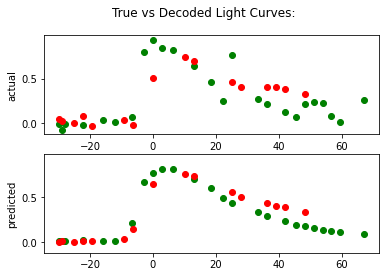

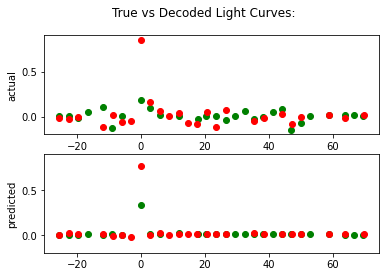

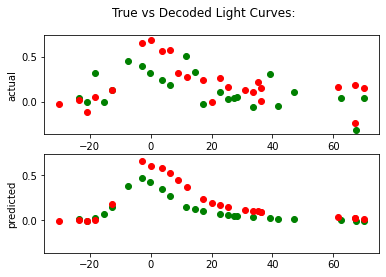

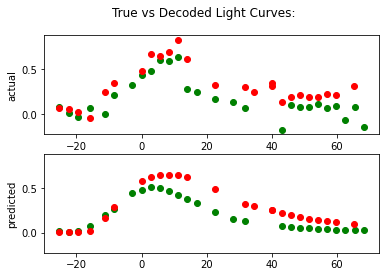

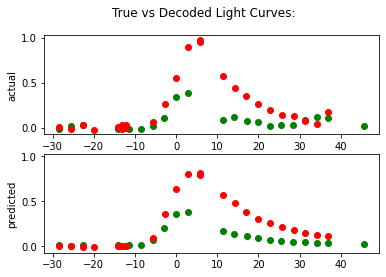

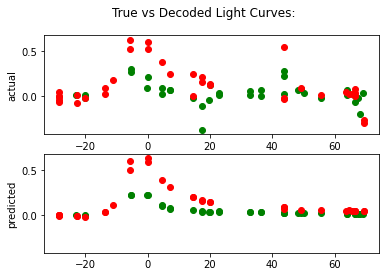

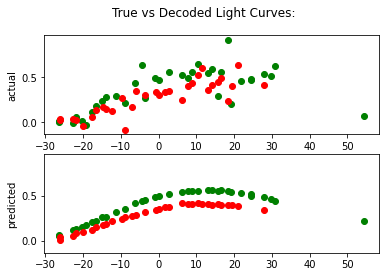

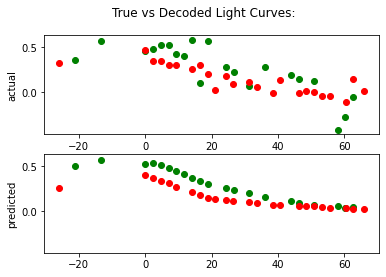

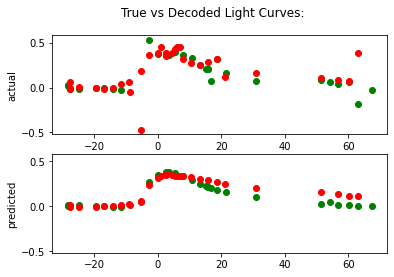

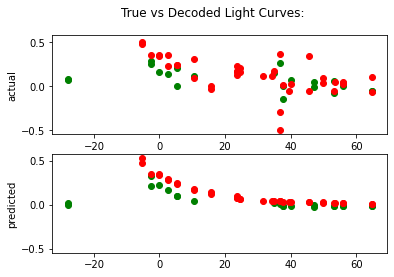

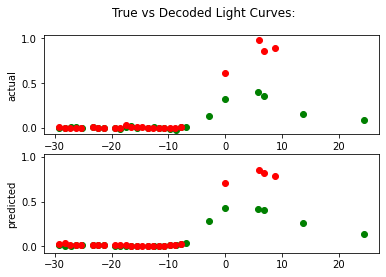

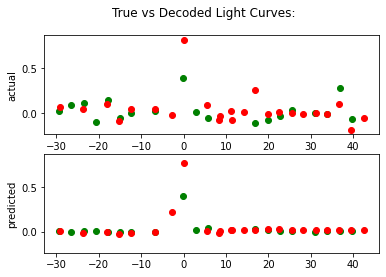

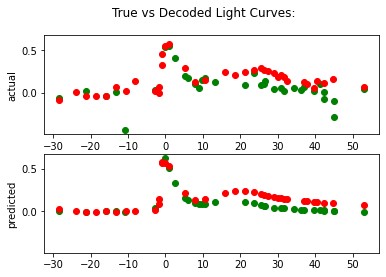

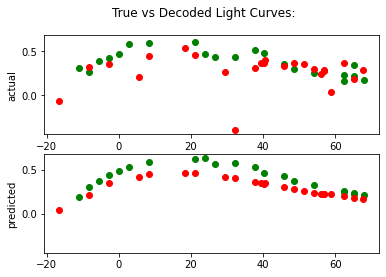

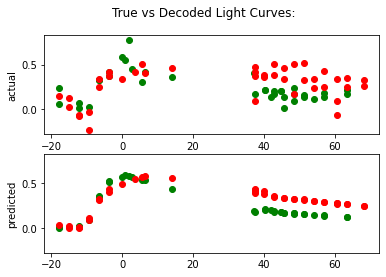

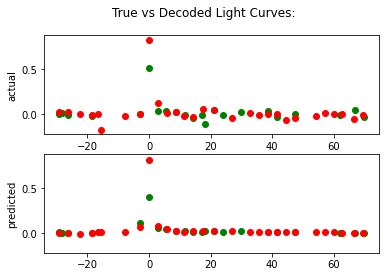

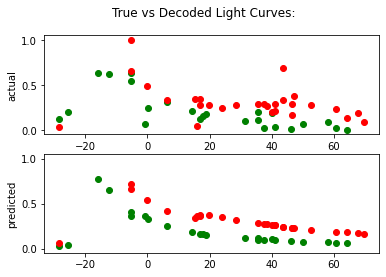

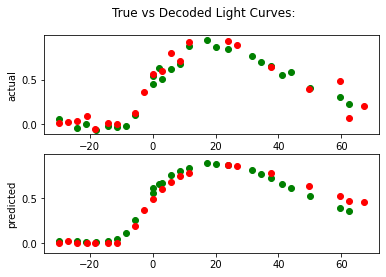

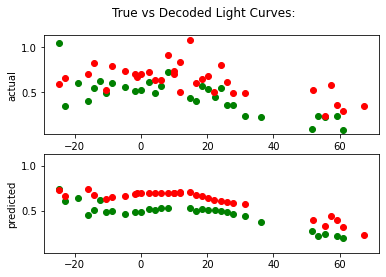

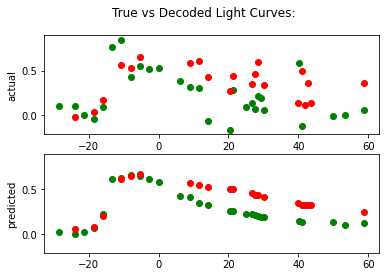

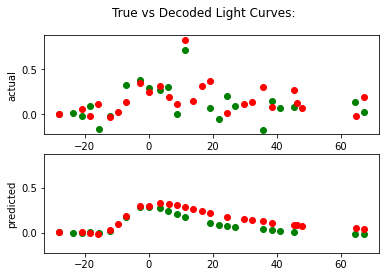

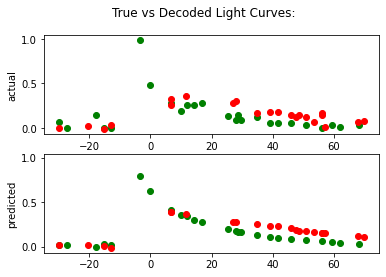

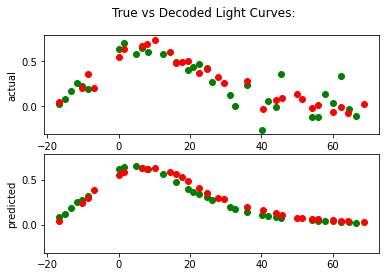

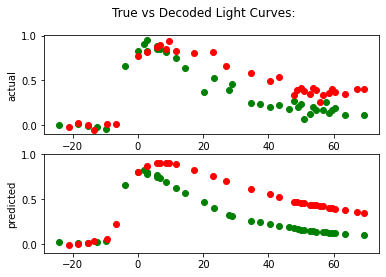

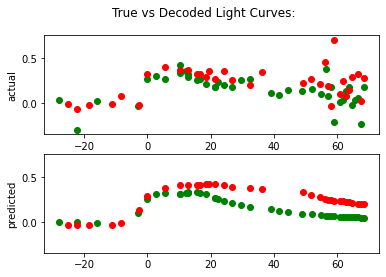

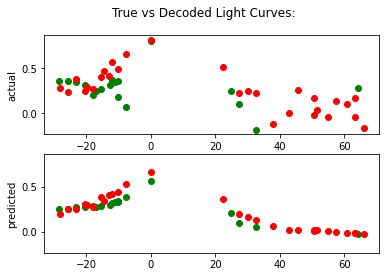

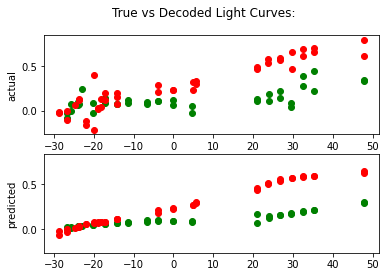

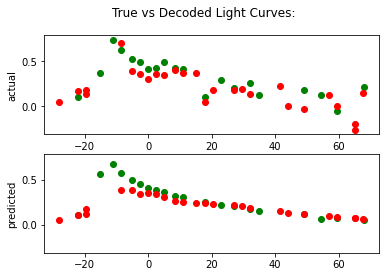

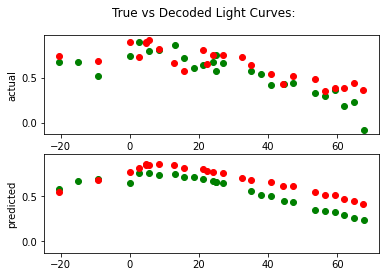

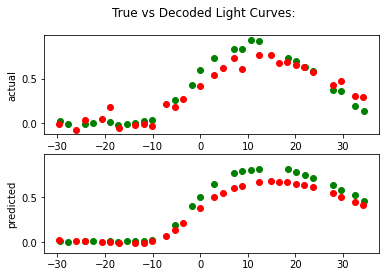

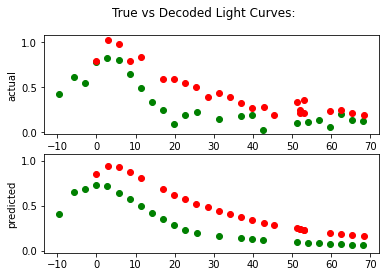

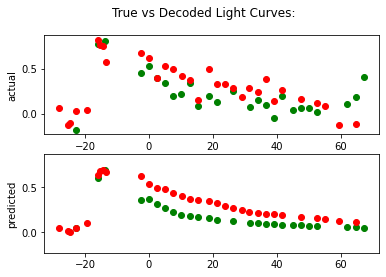

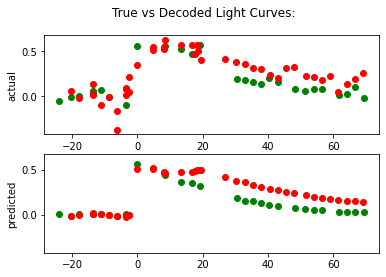

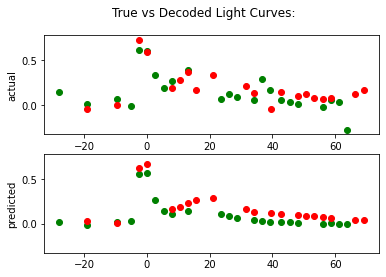

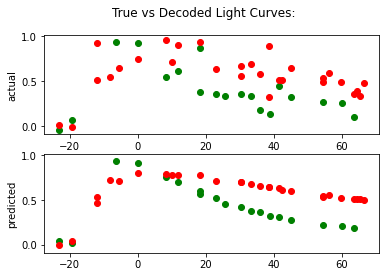

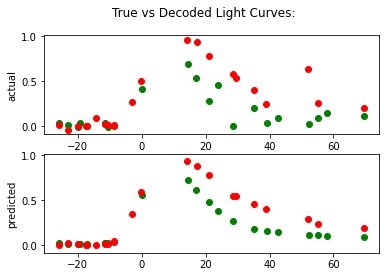

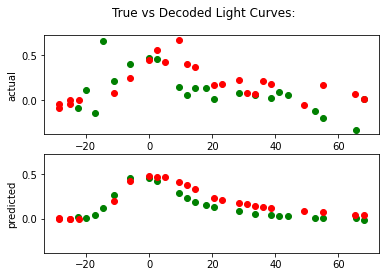

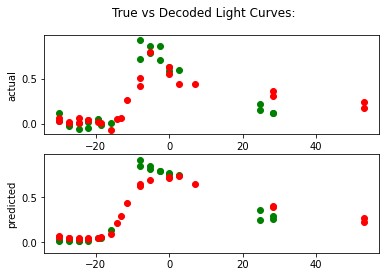

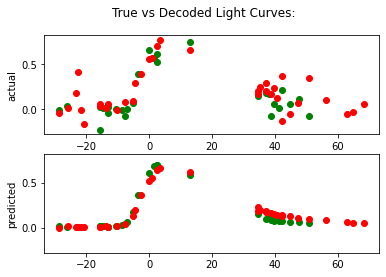

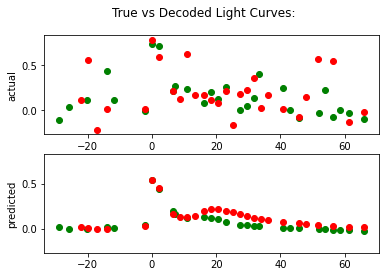

In [ ]:
# test the trained model
x_train, x_test, y_train, y_test = vae.split_prep_data()
vae.test_model(x_test,y_test, 40)

In [ ]:
rvae = VAE(dataset, dataset.shape)
vae = keras.models.load_model(path_to_module + "chck_pts_sim/separated_classes/ckpt_7", custom_objects={
    'VAE':VAE, 'Encoder':Encoder, 
    'Decoder':Decoder, 'Sampling':Sampling,
    'reconstruction_loss':rvae.reconstruction_loss})

building encoder...
building encoder...


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
import random
import joblib
from collections import Counter
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
class RandomForest:

    def __init__(self, labels, prepared_data, encoder):

        # initialize rvae
        self.rvae = VAE(prepared_data, prepared_data.shape)

        # encoded dimension from NN
        self.encoded_dim = self.rvae.latent_dim

        # get training encoder
        self.encoder = encoder

        # augmented data frame
        # self.light_curves = light_curves
        self.labels = labels

        # prepared data
        self.prepared_data = prepared_data

    def create_test_train(self):
        """
        Splits data into 85% training, 15% testing, and unlabeled
        """

        print("Splitting data for RF...")

        # extract all class outputs and inputs
        prep_out = self.labels# np.array([c.loc[0, 'Class'] for c in self.light_curves])
        prep_inp = self.prepared_data

        # extract all training label indexes
        train_indx = [i for i in range(len(prep_out)) if prep_out[i] != 3]
        unclassified_indx = [i for i in range(
            len(prep_out)) if prep_out[i] == 3]
        num_indxs = len(train_indx)

        x_train = []
        y_train = []
        x_test = []
        y_test = []
        x_unclassified = []

        # extract training data
        while len(x_train) < int(num_indxs*0.85):
            ran = random.randint(0, len(train_indx)-1)
            ind = train_indx[ran]
            train_indx.remove(ind)
            x_train.append(prep_inp[ind])
            y_train.append(prep_out[ind])

        # append the rest of the data to testing
        for ind in train_indx:
            x_test.append(prep_inp[ind])
            y_test.append(prep_out[ind])

        # extract unclassified data
        for ind in unclassified_indx:
            x_unclassified.append(prep_inp[ind])

        # change to numpy arrays
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        x_unclassified = np.array(x_unclassified)

        # change y arrays to 1-d arrays
        y_train.shape = (y_train.shape[0],)
        y_test.shape = (y_test.shape[0],)

        print('shape of x_train and x_test:', x_train.shape, x_test.shape)
        print('shape of y_train and y_test:', y_train.shape, y_test.shape)
        print('shape of x_unclassified:', x_unclassified.shape)

        return x_train, x_test, y_train, y_test, x_unclassified

    def make_encodings(self, x_train, x_test, x_unclassified):
        """
        Uses trained encoder to produce 1D encodings of light curves to be used for RF training
        """
        print('making encodings...')

        # encode training light curves
        x_train_enc = self.encoder.predict(
            x_train, workers=32, use_multiprocessing=True, batch_size=128, verbose=1)[2]
        x_test_enc = self.encoder.predict(
            x_test, workers=32, use_multiprocessing=True, batch_size=128, verbose=1)[2]
        if len(x_unclassified) > 0:
          x_unclassified_enc = self.encoder.predict(
              x_unclassified, workers=32, use_multiprocessing=True, batch_size=64, verbose=1)[2]
        else:
          x_unclassified_enc = [[]]
        # x_train_enc = self.encoder.predict_on_batch(x_train)
        # x_test_enc  = self.encoder.predict_on_batch(x_test)
        # x_unclassified_enc = self.encoder.predict_on_batch(x_unclassified)
        
        # numpy arrays
        x_test_enc = np.array(x_test_enc)
        x_train_enc = np.array(x_train_enc)
        x_unclassified_enc = np.array(x_unclassified_enc)

        print('shape of encodings: ', x_train_enc.shape,
              x_test_enc.shape, x_unclassified_enc.shape)

        return x_train_enc, x_test_enc, x_unclassified_enc

    def build_classier(self, x_train, x_test, x_unclassified, y_train, y_test):
        """
        Trains a RF classifier and tests its prediction accuracy
        """
        print('building classifier...')
        rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', min_samples_leaf=40 )

        # reshape
        x_train = x_train.reshape(-1, self.encoded_dim)
        x_test = x_test.reshape(-1, self.encoded_dim)
        x_unclassified = x_unclassified.reshape(-1, self.encoded_dim)


        print('shape of encodings: ', x_train.shape,
              x_test.shape, x_unclassified.shape)

        # fit to data
        rf.fit(x_train, y_train)
        
        # performing predictions on the test dataset
        number_to_class = {0:'SNIa', 1:'SNIbc', 2:'SNIi', 3:'Unclassified', 4:'Other'}
        y_pred = rf.predict(x_test)

        y_train_counter = {number_to_class[key]:value for (key, value) in Counter(y_train).items()}
        y_test_counter = {number_to_class[key]:value for (key, value) in Counter(y_test).items()}
        y_pred_counter = {number_to_class[key]:value for (key, value) in Counter(y_pred).items()}
        print('y_train counts: ', y_train_counter)
        print('y_test counts: ', y_test_counter)
        print('y_pred counts: ', y_pred_counter)

        # check accuracy
        print("ACCURACY OF THE MODEl: ", 100 *
              round(rf.score(x_test, y_test), 2), '%')

       # Create confusion matrix
        conf_mat = pd.crosstab(y_test, y_pred, rownames=[
                               'Actual Species'], colnames=['Predicted Species'])

        print('Confusion Matrix:')
        print(conf_mat.to_string())

        plot_confusion_matrix(rf, x_test, y_test, display_labels = ['SNIa', 'SNIbc', 'SNIi', 'Other'])

        # print('Unlabeled Classifications: ')
        # unlabeled = rf.predict(x_unclassified)
        # print(unlabeled)
        # print(Counter(unlabeled))

        return rf

    def classify(self, rf, index, filename = None):
        """
        Classifies a specific light curve.
        """
        print('classifying specific light curve data...')

        # load file data if file is passed
        if filename:
            raw_df = original_curves
            names = raw_df.loc[:, 'Filename']

            for i in range(len(names)):
                if names[i] == filename:
                    indx = i

            data = self.prepared_data[indx]
            correct = raw_df.loc[indx]['Class']

        # reshape
        # data = data.reshape(1, self.rvae.num_timesteps, self.rvae.num_feats)

        # encode data
        data = self.encoder.predict(data)[2]

        # make class num -> classification dict
        classes = {0: 'SNIa', 1: 'SNIbc', 2: 'SNII',
                   3: 'Other', 4: 'Unclassified'}

        # make prediction from data
        pred = rf.predict(data)

        # print confidence
        probs = np.array(rf.predict_proba(data)[0])
        print('Number of different possible predictions: ', len(probs))
        highest_prob_ind = np.argmax(probs)
        highest_prob = max(probs)
        print('Prediction is ' + classes[highest_prob_ind]+' (',
              pred[0], ') with '+str(int(highest_prob*100))+'% confidence')
        print('Correct classification should be: ',
              classes[correct], ' (', correct, ')')

# %%

building encoder...
Splitting data for RF...
shape of x_train and x_test: (6800, 80, 4) (1200, 80, 4)
shape of y_train and y_test: (6800,) (1200,)
shape of x_unclassified: (0,)
making encodings...
shape of encodings:  (6800, 30) (1200, 30) (1, 0)
building classifier...
shape of encodings:  (6800, 30) (1200, 30) (0, 30)
y_train counts:  {'SNIbc': 1709, 'Other': 1692, 'SNIa': 1707, 'SNIi': 1692}
y_test counts:  {'SNIa': 293, 'SNIbc': 291, 'SNIi': 308, 'Other': 308}
y_pred counts:  {'SNIa': 364, 'SNIi': 312, 'SNIbc': 222, 'Other': 302}
ACCURACY OF THE MODEl:  64.0 %
Confusion Matrix:
Predicted Species    0    1    2    4
Actual Species                       
0                  209   36   29   19
1                   88  152   34   17
2                   39   25  192   52
4                   28    9   57  214


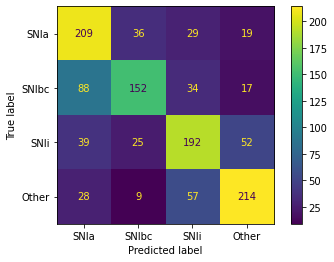

In [ ]:
# print(light_curves)
# rvae = VAE(prepared_data, prepared_data.shape)
# vae = keras.models.load_model(path_to_module + "chck_pts_sim/ckpt_100_unit_data", custom_objects={'VAE':VAE, 'Encoder':Encoder, 
#                                                                                                                               'Decoder':Decoder, 'Sampling':Sampling,
#                                                                                                                               'reconstruction_loss':rvae.reconstruction_loss})
rf= RandomForest(labels,dataset, vae.encoder)


# split data set for supervised training
x_train, x_test, y_train, y_test, x_unclassified= rf.create_test_train()
# print(x_train)
# encode input data
x_train_enc,x_test_enc,x_unclassified_enc=rf.make_encodings(x_train, x_test, x_unclassified)

# build and train the classifier
classifier = rf.build_classier(x_train_enc,x_test_enc,x_unclassified_enc,y_train,y_test)



In [ ]:
indexes=[0, 4000]
for i in indexes:
  correct = labels[i]
  # shape should be (1, 300, 4)
  light_curve = np.array([dataset[i]])
  encoded_lc = rf.encoder.predict(light_curve)[2]
  # make prediction from data
  pred = classifier.predict(encoded_lc)
  # make class num -> classification dict
  classes = {0: 'SNIa', 1: 'SNIbc', 2: 'SNII',
              3: 'Other', 4: 'Unclassified'}

  # print confidence
  probs = np.array(classifier.predict_proba(encoded_lc)[0])
  print('Number of different possible predictions: ', len(probs))
  highest_prob_ind = np.argmax(probs)
  highest_prob = probs[highest_prob_ind]
  print("Probabilities:", probs)
  print('Prediction is ' + classes[highest_prob_ind]+' (',
        pred[0], ') with '+str(int(highest_prob*100))+'% confidence')
  print('Correct classification should be: ',
        classes[correct], ' (', correct, ')')
  print()

Number of different possible predictions:  4
Probabilities: [0.18986362 0.26441234 0.3839942  0.16172984]
Prediction is SNII ( 2 ) with 38% confidence
Correct classification should be:  SNIa  ( 0 )

Number of different possible predictions:  4
Probabilities: [0.23958288 0.28012437 0.32300461 0.15728815]
Prediction is SNII ( 2 ) with 32% confidence
Correct classification should be:  SNII  ( 2 )

